# description 6/03/19 clinically guided aggregation modeling w/ 2 elix variables

sklearn modeling using local methods of the median imputed training data using origional min/max clinically guided aggregation. note the preprocessing of data from 07.20-worst_case_model was performed in R (09.newagg2_preprocessing_med_impute.rmd). this eventually will be converted over to python, but for now works in r. 

preprocessing includes variable formatting (categorical to factor variables in r, train/test split, and median imputation).


In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, pairwise, f1_score, log_loss, make_scorer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.joblib import Memory
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, Imputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import validation
from scipy.sparse import issparse
from scipy.spatial import distance
from sklearn import svm

#importin xg boost and all needed otherstuff
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier #conda install -c conda-forge xgboost to install
##adding these, lets see if it helps with xgboost crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#reducing warnings that are super common in my model
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore') #ignore all warnings

memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

RANDOM_STATE = 15485867

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 53.1 ms


# importing and formatting dataset

In [111]:
#cohort import

os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'


final_pt_df2 = pd.read_csv(Path(wd + '/data/raw/csv/04042019_final_pt_df2_v.csv') , index_col=0) #only for patients with minimum vitals, 14478 icustay_id
patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 85.7 ms


In [112]:
# ##24 hr sensitivity
# #importing in all clinical_variable files
lower_window=0
upper_window=1
time_col="charttime"
time_var="t_0"
folder="{}_hr_window".format(timewindowdays)
timewindowdays="24"
date= '09062019'
patient_df= final_pt_df2

# #48 hr sensitivity
# lower_window=0
# upper_window=2
# time_var="t_0"
# timewindowdays="48"
# folder="{}_hr_window".format(timewindowdays)
# date='16052019'
# time_col="charttime"
# time_var= 't_0'
# patient_df= final_pt_df2

# #72 hr elixhauser-redo
# date='11062019'
# lower_window=0
# upper_window=3
# timewindowdays="72"
# folder="{}_hr_window".format(timewindowdays)
# time_col="charttime"
# time_var= 't_0'
# patient_df= final_pt_df2

time: 16.2 ms


In [113]:
#importing in all clinical_variable files
os.chdir(r'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/')
train_data= pd.read_csv(Path(wd+'/data/processed/merged/{}_worst_df_train_preImp_{}.csv'.format(date,timewindowdays),  index_col=0))
test_data= pd.read_csv(Path(wd+'/data/processed/merged/{}_worst_df_test_preImp_{}.csv'.format(date,timewindowdays),  index_col=0))


time: 92.5 ms


In [114]:
vaso_active=['phenylephrine',
            'norepinephrine',
            'vasopressin',
            'dobutamine',
            'dopamine',
            'epinephrine'] 

ordinal=[
            'leukocyte',
            'nitrite',
            'vent_recieved',
            'o2_flow',
            'rrt',
            'pao2fio2ratio',
            'cancer_elix',
            "any_vasoactives",
            'bands',
            'pco2'
]

categorical=[
            "ethnicity",
            'gender'
]

### 06/18/19 changed this to be consistent with the 07.20 model_aggregation notebook
categorical_variables= vaso_active+ordinal+categorical

time: 6.99 ms


In [160]:
def preprocessing(preimp_df):

    """
    1) rename columns
    2) standardize last 2 columns to be standardized
    3) convert categorical columns to proper format
    4) median impute
    """
    from sklearn.impute import SimpleImputer
    global categorical_variables
        
    rename_dic={
    "('max', 'sodium')": "maxSodium" ,
    "('max', 'sodium')" : "maxSodium",
    "('min', 'sodium')" : "minSodium",
    "('max', 'calcium')" : "maxCalcium",
    "('min', 'calcium')" : "minCalcium",
    "('max', 'sodium')": "maxSodium",
    "('min', 'sodium')": "minSodium",
    "('max', 'wbc')": "maxWBC",
    "('min', 'wbc')": "minWBC",
    "any_vasoactive": "any_vasoactives"
        }
    data=preimp_df.copy()
    data=data.rename(rename_dic, axis='columns').copy()
    
    ### onehot encoding categorical var
    cols_to_transform=categorical_variables
    data = pd.get_dummies(data, columns = cols_to_transform, drop_first=True)
    
    
    #binarizing and poping outcome for training data
    data.loc[data['final_bin']=="C_pos/A_full","final_bin"]=1
    data.loc[data['final_bin']=="C_neg/A_partial","final_bin"]=0
    data['final_bin']=pd.to_numeric(data['final_bin'])
    
    
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    data=pd.DataFrame(imp.fit_transform(data), columns=list(data))

    ## establishing training data and labels
    x_train= data.copy()
    z_icustay_id=x_train.pop('icustay_id')
    y_train= x_train.pop("final_bin").values
    
    return(x_train, y_train, z_icustay_id, data)

# x_train, y_train, z_icustay_id= preprocessing(pd.merge(preimp_train_df, final_pt_df2[['icustay_id','final_bin']]))

time: 36.7 ms


In [161]:
x_train, y_train, z_icustay_id, train_data = preprocessing(pd.merge(train_data, final_pt_df2[['icustay_id','final_bin']]))
x_test, y_test, z_icustay_id_test, test_data= preprocessing(pd.merge(test_data, final_pt_df2[['icustay_id','final_bin']]))
#for local modeling
# all_xy=xy_preprocessing(train_data)
# all_xy_test=xy_preprocessing(test_data)

time: 149 ms


In [117]:
train_data.head()

,icustay_id,any_vasoactives,bilirubin,bun,cancer_elix,chloride,creatinine,daily_sofa,dobutamine,dopamine,...,"('max', 'sodium')","('max', 'wbc')","('min', 'calcium')","('min', 'sodium')","('min', 'wbc')",ethnicity,gender,bands,pao2fio2ratio,pco2
0,200030.0,1.0,NaN,0.073928,0.0,0.020529,0.000000,-0.178747,1.0,0.0,...,0.011917,0.127248,0.082467,0.007973,0.127248,black,1,NaN,NaN,NaN
1,200033.0,1.0,NaN,-0.096406,1.0,-0.008482,-0.234465,-0.430677,0.0,0.0,...,-0.004030,-0.186487,-0.424307,-0.012177,-0.186487,white/nonhispanic,1,NaN,NaN,NaN
2,200036.0,0.0,NaN,NaN,0.0,NaN,NaN,-0.430677,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,white/nonhispanic,1,NaN,NaN,NaN
3,200061.0,0.0,1.528874,-0.181963,0.0,-0.012783,-0.074001,0.000000,0.0,0.0,...,-0.004030,0.178596,NaN,-0.004030,0.178596,unknown/other,1,NaN,NaN,NaN
4,200063.0,0.0,NaN,-0.136324,0.0,-0.004221,0.263034,0.347709,0.0,0.0,...,-0.008089,-0.107093,-0.252128,-0.008089,-0.107093,unknown/other,1,NaN,NaN,NaN


time: 32.7 ms


#### optional qc

In [118]:
#x_train.iloc[1:5, 25:45]

time: 753 µs


In [119]:
#x_train.iloc[1:5, 35:65]

time: 712 µs


In [120]:
#x_train.iloc[1:5, 10:30]

time: 742 µs


## looking at correlation of all variables

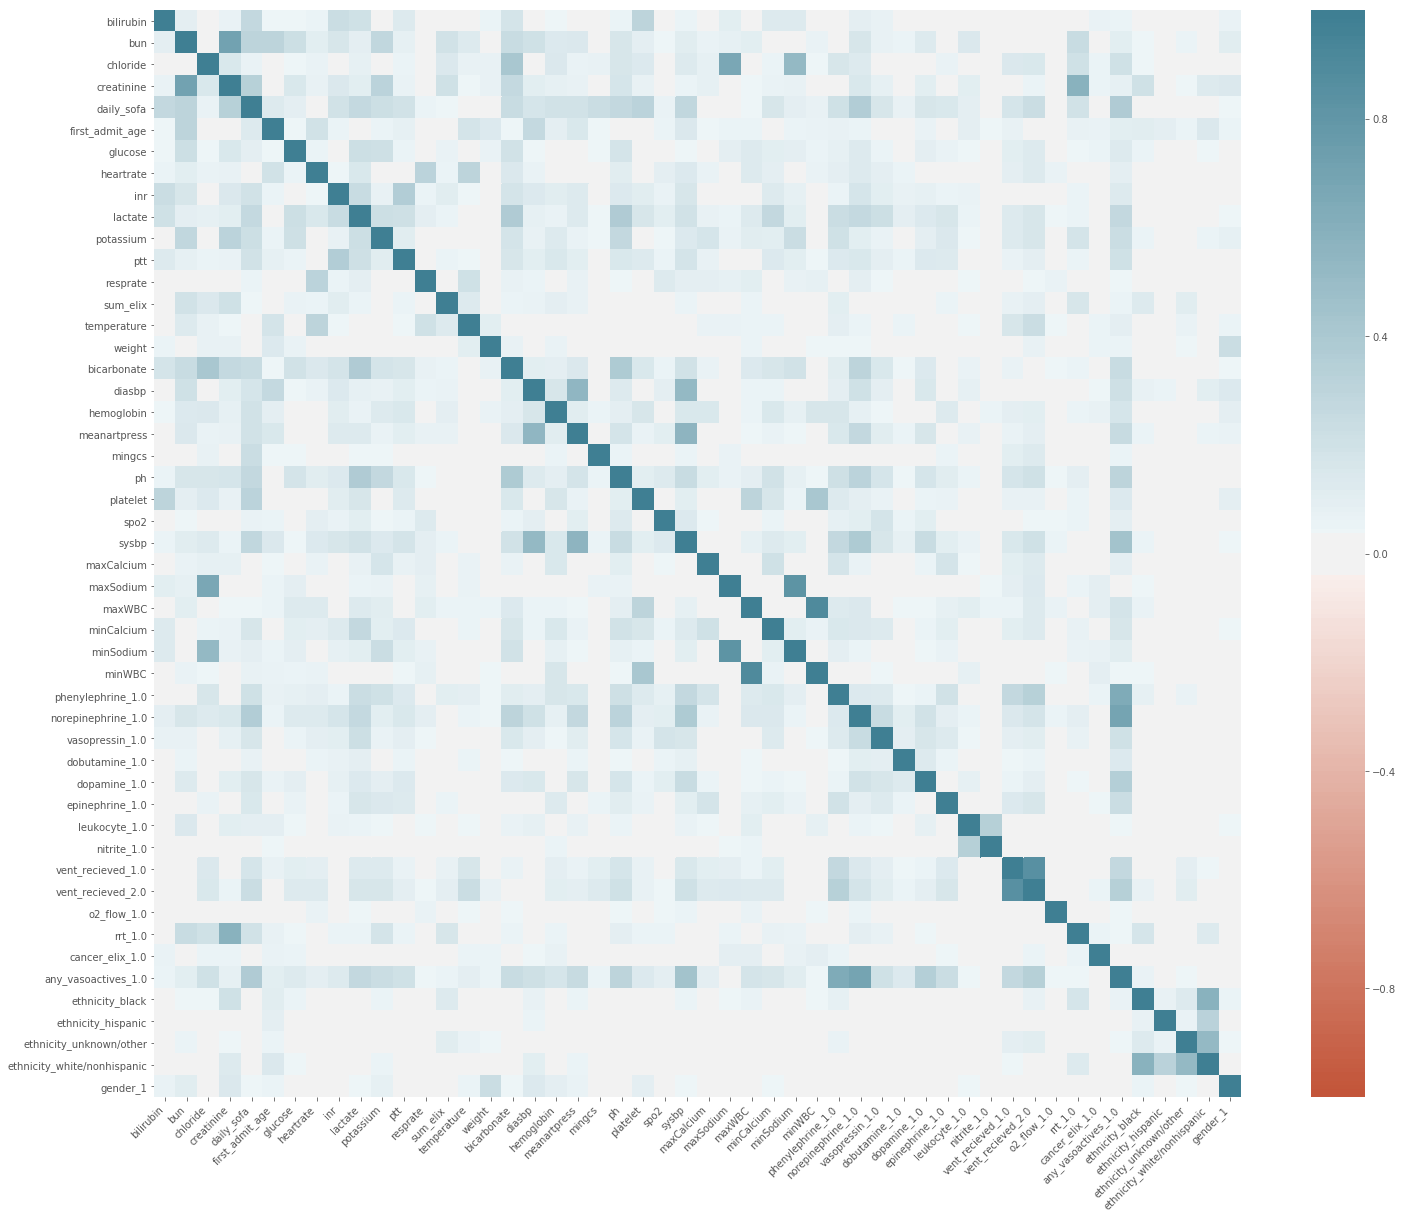

time: 1.34 s


In [121]:
corr = x_train.corr().abs()

plt.figure(figsize=(25, 20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [122]:
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
cor_df=pd.DataFrame(sol)#.sort_values(kind="quicksort") #[-10:0])
cor_df=cor_df.reset_index()
cor_df=cor_df.rename(columns={'level_0': 'corx', 'level_1': 'cory', 0:'corr'})
cor_df2=cor_df[(cor_df['corx']!=cor_df['cory']) & (cor_df['corr']>0.7)].sort_values('corr', ascending=False)
cor_df2.head()

,corx,cory,corr
0,maxWBC,minWBC,0.901099
1,vent_recieved_1.0,vent_recieved_2.0,0.846490
2,maxSodium,minSodium,0.825086
3,bun,creatinine,0.713485


time: 19.9 ms


### DROPING one of the 2 columns with correlation >0.7

	corx	cory	corr
0	ipco2_absent	pao2fio2Ratio_(475, 3000]	0.872418
1	maxWBC	minWBC	0.802373
2	bun	creatinine	0.720861
3	maxSodium	minSodium	0.704233

In [123]:
x_train.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')
x_test.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')
# all_xy.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')
# all_xy_test.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')

time: 5.04 ms


### formatting x and y for modleing

In [124]:
#x=np.array(x_train.iloc[:,[1,2,3,4,5,6,7,8,9,38,39,40,41]]).copy() #copy of x_train
x=np.array(x_train.copy())

#x=np.array(train_data.iloc[:,[1,2,3,4]]).copy() #copy of x_train
#train_data.iloc[:,[1,2,3,4,5]] ###drastically reducing my dataframe size to test algorithm
y=y_train.copy() #copy of y_train
y=y.astype('int')
##all_xy: train data with finalbin:label and index=icustay_id
#all_xy=train_data.copy().set_index("icustay_id").rename(columns={'final_bin':"label"}) #

time_interval=4

time: 5.06 ms


In [125]:
print(len(x_train),len(x_test))

5316 2272
time: 877 µs


# Modelbuilding
* step1) hypertune xgb on 5fold cv.
* step2) test entire trainset and predict trainset.
* step3) run hypertuned model on 5fold cv with lr and get overall metrics.
* step4) local model testing

## step1) XGB hypertuning

In [126]:
def evaluate(model, test_features, test_labels):
    from sklearn.metrics import log_loss
    
    y_hat = model.predict(test_features)
    errors = abs(y_hat - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    auc=roc_auc_score(test_labels, y_hat)
    loss= log_loss(test_labels, y_hat)
    
    print ('the AUC is: {:0.2f}'.format(auc))
    print ('the logloss is: {:0.2f}'.format(loss))
    print(confusion_matrix(test_labels, y_hat))
    
    return loss


time: 9.88 ms


In [127]:
def hypertuning_fxn(X, y, nfolds, model , param_grid, base_model, scoring="neg_log_loss", gridsearch=True, n_iter=20): 
    if gridsearch==True:
        grid_search = GridSearchCV(estimator= model,
                                         param_grid=param_grid,
                                         cv=nfolds,
                                         scoring=scoring,
                                         return_train_score=True,
                                         n_jobs = -1)
    else:
        grid_search = RandomizedSearchCV(estimator= model,
                                         param_distributions= param_grid,
                                         n_iter=n_iter,
                                         cv=nfolds,
                                         scoring=scoring,
                                         return_train_score=True,
                                         n_jobs = -1)
    grid_search.fit(X, y)    
    
    print("Grid scores on development set:")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
    #grid_search.best_params_
    print(grid_search.best_score_)
    print("\n")
    print(grid_search.best_params_)
    
    print('\n base model:')
    base_model = base_model#(random_state = 42)
    base_model.fit(x, y)
    base_auc = evaluate(base_model, x, y)
    
    print('\n hypertuned model:')
    best_random = grid_search.best_estimator_
    random_auc = evaluate(best_random, x, y)

    print('logloss change of {:0.2f}%. after hypertuning on training set (may be overfit)'.format( 100 * (random_auc - base_auc) / base_auc))
    
    print(grid_search.best_estimator_)
    
    return(grid_search)

time: 54.9 ms


In [128]:
###xgboost
model= XGBClassifier(n_estimators=100, min_child_weight=2, #changed: GridSearchCV ->RandomizedSearchCV
                                              gamma=0, subsample=0.8, colsample_bytree=0.8,
                                              objective='binary:logistic', n_jobs=-1, seed=27)
scale_pos_weight = [0.1, 1, 5, 10]
max_depth = [1, 2, 3, 4, 5]
learning_rate=[0.01, 0.1, 0.5, 1]
param_grid = {'scale_pos_weight': scale_pos_weight, 'max_depth' : max_depth, "learning_rate":learning_rate}

base_model=XGBClassifier(random_state = 42)
xgboost_hyper=hypertuning_fxn(x, y, nfolds=5, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=20, gridsearch=True)

Grid scores on development set:
-0.577 (+/-0.005) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 0.1}
-0.568 (+/-0.006) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 1}
-0.753 (+/-0.002) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 5}
-0.893 (+/-0.002) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 10}
-0.568 (+/-0.005) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 0.1}
-0.551 (+/-0.006) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 1}
-0.724 (+/-0.005) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 5}
-0.861 (+/-0.004) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 10}
-0.562 (+/-0.004) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 0.1}
-0.543 (+/-0.006) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 1}
-0.705 (+/-0.007) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 5}
-0.837 (+/-0.008) for {'l

In [129]:
###rf
# Number of trees in random forest
#n_estimators = [100, 1000]#[int(x) for x in np.linspace(start = 10, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = [3,'auto', 10 ]
# Maximum number of levels in tree
max_depth = [5,10, 25]#[int(x) for x in np.linspace(5, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10]
# Method of selecting samples for training each tree
#bootstrap = [True, False]

#class_weight is either a dictionary of each class to a uniform weight for that class (e.g., {1:.9, 2:.5, 3:.01}), or is a string telling sklearn how to automatically determine this dictionary.
class_weight= [None,{0:1, 1:4}, {0:(1/np.bincount(y))[0], 1:(1/np.bincount(y))[1]}]


param_grid = {#'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight}


model= RandomForestClassifier(criterion='entropy')
base_model=RandomForestClassifier(random_state = 42, criterion='entropy')

rf_hyper=hypertuning_fxn(x, y, nfolds=10, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss",n_iter = 30, gridsearch=True)


Grid scores on development set:
-0.514 (+/-0.014) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
-0.512 (+/-0.016) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
-0.515 (+/-0.015) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 10}
-0.515 (+/-0.017) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
-0.511 (+/-0.018) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 5}
-0.511 (+/-0.017) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 10}
-0.510 (+/-0.021) for {'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}
-0.513 (+/-0.027) for {'class_weight': None, 'max_depth': 5, 'max_features':

## Hypertune SVC

In [130]:
model= svm.SVC(probability=True)
kernel = ['linear', 'rbf', 'poly']
gamma = [0.1, 1, 'auto'] #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default=’auto’ uses 1 / n_features
C = [1, 10, 100] #Penalty parameter C of the error term.
degree = [0, 1, 2]
class_weight=['balanced', None]

param_grid = {'kernel': kernel,
              'gamma': gamma,
              'C': C,
              'degree': degree,
              'class_weight':class_weight}

base_model=svm.SVC(probability=True)

svc_hyper=hypertuning_fxn(x, y, nfolds=4, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=10, gridsearch=False)

Grid scores on development set:
-0.494 (+/-0.013) for {'kernel': 'linear', 'gamma': 'auto', 'degree': 1, 'class_weight': 'balanced', 'C': 1}
-0.491 (+/-0.013) for {'kernel': 'linear', 'gamma': 1, 'degree': 2, 'class_weight': 'balanced', 'C': 10}
-0.491 (+/-0.014) for {'kernel': 'poly', 'gamma': 1, 'degree': 1, 'class_weight': 'balanced', 'C': 100}
-0.524 (+/-0.025) for {'kernel': 'poly', 'gamma': 'auto', 'degree': 2, 'class_weight': 'balanced', 'C': 1}
-0.490 (+/-0.012) for {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'class_weight': 'balanced', 'C': 10}
-0.495 (+/-0.010) for {'kernel': 'rbf', 'gamma': 0.1, 'degree': 1, 'class_weight': 'balanced', 'C': 1}
-0.583 (+/-0.001) for {'kernel': 'poly', 'gamma': 0.1, 'degree': 0, 'class_weight': 'balanced', 'C': 1}
-0.519 (+/-0.015) for {'kernel': 'rbf', 'gamma': 0.1, 'degree': 0, 'class_weight': None, 'C': 100}
-0.582 (+/-0.000) for {'kernel': 'poly', 'gamma': 0.1, 'degree': 0, 'class_weight': None, 'C': 1}
-0.498 (+/-0.021) for {'kernel':

In [131]:
###knn
from sklearn.neighbors import KNeighborsClassifier
model= KNeighborsClassifier()

n_neighbors = [3,4,5, 8, 10, 25]
weights=['uniform']
p=[1,2] #1= mmanhattan, 2= euclidian


param_grid = {'n_neighbors': n_neighbors,
              'weights': weights,
              'p': p}

base_model=KNeighborsClassifier()

knn_hyper=hypertuning_fxn(x, y, nfolds=10, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=40, gridsearch=True)

Grid scores on development set:
-4.042 (+/-0.590) for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
-3.977 (+/-0.893) for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
-3.038 (+/-0.446) for {'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
-3.107 (+/-0.758) for {'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}
-2.495 (+/-0.321) for {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
-2.410 (+/-0.731) for {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
-1.647 (+/-0.428) for {'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
-1.506 (+/-0.265) for {'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}
-1.246 (+/-0.356) for {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
-1.171 (+/-0.275) for {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
-0.628 (+/-0.169) for {'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
-0.577 (+/-0.072) for {'n_neighbors': 25, 'p': 2, 'weights': 'uniform'}
-0.5774237588081521


{'n_neighbors': 25, 'p': 2, 'weights': 'uniform'}

 base model:
the AUC is: 0.68
the loglo

In [132]:
knn_hyper.best_params_

{'n_neighbors': 25, 'p': 2, 'weights': 'uniform'}

time: 2.62 ms


# Hypertuned Model Initialization

In [133]:
def reset_model(model_name, hardcode=True):
    if hardcode==True:
        if model_name== 'xgboost':
            model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
               max_depth=4, min_child_weight=2, missing=None, n_estimators=100,
               n_jobs=-1, nthread=None, objective='binary:logistic',
               random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=27, silent=True, subsample=0.8)
            

        elif model_name== 'logreg':
            model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                    intercept_scaling=1, class_weight='balanced', random_state=None)

        elif model_name== 'rf':
            model = RandomForestClassifier(bootstrap=False, class_weight={0: 1, 1: 4},
                criterion='entropy', max_depth=10, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_impurity_split=None, min_samples_leaf=2,
                min_samples_split=2, min_weight_fraction_leaf=0.0,
                n_estimators=600, n_jobs=None, oob_score=False,
                random_state=None, verbose=0, warm_start=False)

        elif model_name== 'svc':
            model = svm.SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
                  decision_function_shape='ovr', degree=0, gamma=1, kernel='linear',
                  max_iter=-1, probability=True, random_state=None, shrinking=True,
                  tol=0.001, verbose=False)
            
        elif model_name== 'knn':
            model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                   metric_params=None, n_jobs=None, n_neighbors=25, p=1,
                   weights='uniform')
    
    else:
            if model_name== 'xgboost':
                model = xgboost_hyper.best_estimator_

            elif model_name== 'logreg':
                model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                        intercept_scaling=1, class_weight='balanced', random_state=None)

            elif model_name== 'rf':
                model = rf_hyper.best_estimator_

            elif model_name== 'svc':
                model = svc_hyper.best_estimator_
                
            elif model_name== 'knn':
                model = knn_hyper.best_estimator_
    return(model)

time: 87.1 ms


# test entire trainset and predict testset.
*<del> step1) hypertune xgb on 5fold cv.
* step2) test entire trainset and predict testset.
* step3) local model testing

In [134]:
def get_auc_score(model,train_index, x=x,y=y):
    y_pred_proba = model.predict_proba(x[train_index])[:, 1] 
    roc_score=roc_auc_score(y[train_index], y_pred_proba)
    return(roc_score)

time: 3.48 ms


## youden index and plotting functions

In [135]:
def optimal_youden_index(fpr, tpr, thresholds, tp90=True):
    """
    inputs fpr, tpr, thresholds from metrics.roc(),
    outputs the clasification threshold, roc dataframe, and the index of roc dataframe for optimal youden index
    """
    #making dataframe out of the thresholds
    roc_df= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
    roc_df.iloc[0,0] =1
    roc_df['yuden']= roc_df['tpr']-roc_df['fpr']
    
    if tp90==True:
        idx= roc_df[roc_df['tpr']>=0.9]['yuden'].idxmax() #changed this so now finds optimial yuden threshold but tp>=90%
    else:
        idx=roc_df['yuden'].idxmax() #MAX INDEX
    
    youden_threshold=roc_df.iloc[idx,0] #threshold for max youden
    return(youden_threshold, roc_df, idx)
    
def plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=False,model_name=None, folder_name=None, file_name=None):
    plt.title('ROC with optimal Youden Index')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    
    #finding the point on the line given threshold 0.5 (finding closest row in roc_df)
    og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
    plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='x', markersize=5, color="g")
    plt.annotate(s="P(>=0.5)",xy=(roc_df.iloc[og_idx,1]+0.02, roc_df.iloc[og_idx,2]-0.04),color='g') #textcoords
    
    
    plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=5, color="r") ##
    plt.annotate(s="M_Youden",xy=(roc_df.iloc[idx,1]+0.02, roc_df.iloc[idx,2]-0.04),color='r' ) #textcoords
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    if save==True:
        if folder_name != None:
            address = 'figures/{}/'.format(folder_name)
        else:
            address = 'figures/'
        if not os.path.exists(address):
            os.makedirs(address)
        plt.savefig(address+"/{}_{}.png".format(model_name,file_name),bbox_inches='tight')
    else: pass
    
    plt.show()
    
def plot_table_as_fig(table_in, col_labels, row_labels, save=False,model_name=None,folder_name=None, file_name=None,figsize=(6,1)):
    
    fig = plt.figure(figsize=figsize)
    table = plt.table(cellText = table_in, 
                  colLabels = col_labels,
                  rowLabels = row_labels,
                  loc='best')
    plt.axis("tight")
    plt.axis('off')
    if save==True:
        if folder_name != None:
            address = 'figures/{}/'.format(folder_name)
        else:
            address = 'figures/'
        if not os.path.exists(address):
            os.makedirs(address)
        plt.savefig(address+"/{}_{}.png".format(model_name,file_name),bbox_inches='tight')
    else: pass
    
    plt.show()
    

time: 181 ms


In [136]:
def classifier_eval(model, x=x, y=y, proba_input=False,pos_label=1, print_default=True, save=False,model_name=None, folder_name=None):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score

    """
    catchall classification evaluation function. will print/save the following:
    
    print/save the following:
        ROC curve marked with threshold for optimal youden (maximizing tpr+fpr with constraint that tpr>0.9)

        using 0.5 threshold:
            confusion matrix
            classification report
            npv
            accuracy


        using optimal youden (maximizing tpr+fpr with constraint that tpr>0.9):
            confusion matrix
            classification report
            npv
            accuracy
    
    output: 
        outputs modelname, auc, precision, recall, f1, and npv to a dictionary. 
    
    notes:
    youden's J statistic:
    J= sensitivity + specificity -1
    (truepos/ truepos+falseneg) + (true neg/ trueneg + falsepos) -1
    
    """
    if save==True: #making folder if one doesn't exist
        if folder_name != None:
            address = '../figures/{}/'.format(folder_name)
        else:
            address = 'train/'
        if not os.path.exists(address):
            os.makedirs(address)
    
    if proba_input==True:  #incorporating classifier_eval2() functionality into this (ie allowing user to input a y_proba instead of a model)
        y_proba= model
        y_pred=[1 if y >= 0.5 else 0 for y in y_proba]
    
    else:
        model_name=type(model).__name__

        y_pred = model.predict(x)
        y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)

    #plotting roc
    plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=save, model_name=model_name,folder_name=folder_name, file_name='roc')
    plt.show(), plt.close()
    
    #printing npv, recall, precision, accuracy
    npv=confusion_matrix(y, y_pred)[0,0]/sum(np.array(y_pred)==0)*100
    prec= precision_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    recall= recall_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    f1= f1_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    
    if print_default==True: ###can opt to not print the 0.5 classification threshold classification report/conf matrix
        #plotting confusion matrixs
        print("\n******* Using 0.5 Classification Threshold *******\n")
        print(confusion_matrix(y, y_pred))
        print ('the Accuracy is: {:01.2f}'.format(accuracy_score(y, y_pred)))
        print ("npv: {:01.2f}".format(npv))
        print ('the classification_report:\n', classification_report(y,y_pred))
    else:
        pass
    
    #### YOUDEN ADJUSTMENT #####

    print("\n******* Using Optimal Youden Classification Threshold *******\n")
    print("\nthe Youden optimal index is : {:01.2f}".format(youden_threshold))

    y_pred_youden = [1 if y >= youden_threshold else 0 for y in y_proba]

    npv_y=confusion_matrix(y, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0)*100
    prec_y= precision_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)*100
    recall_y= recall_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)*100
    f1_y= f1_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)*100
    auc_y=roc_auc_score(y_true=y, y_score= y_proba)*100
    
    ##plotting and saving confusion matrix
    confusion_youden=confusion_matrix(y, y_pred_youden)
    
    plot_table_as_fig(confusion_youden,
                  col_labels=['predicted_neg','predicted_pos'],
                  row_labels=['true_neg',"true_pos"],
                  save=save,
                  figsize=(6,1),
                  model_name=model_name,
                  folder_name=folder_name,
                  file_name='y_confusion')
    plt.show(), plt.close()
   
    #print(confusion_matrix(y, y_pred_youden))
    print("the Accuracy is: {:01.2f}".format(accuracy_score(y, y_pred_youden)))
    print("npv: {:01.2f}".format(npv_y))
    
    ###formatting classification report to be compatable with matplotlib table
    report_youden=classification_report(y,y_pred_youden,output_dict=True)  
    report_youden = pd.DataFrame.from_dict(report_youden).transpose()[['precision','recall','f1-score','support']]
    report_youden = np.round(report_youden,2)
    
    ##plotting and saving classification report
    plot_table_as_fig(table_in=np.array(report_youden),#classification_report(y, xgboost.predict(x))),
                      col_labels=['precision','recall','f1-score','support'],
                      row_labels=['neg',"pos","micro_avg","macro_avg",'weighted_avg'],
                      figsize=(15,5),
                      save=save,
                      model_name=model_name,
                      folder_name=folder_name,
                      file_name='y_report')
    plt.show(), plt.close()
    
    youden_dic= {'model':model_name, 'auc':auc_y, 'precision':prec_y, 'recall':recall_y, 'f1':f1_y, 'npv':npv_y}
    return(youden_dic)
    

time: 253 ms


In [137]:
### label youden index

time: 499 µs


# testing global model

## test entire trainset and predict trainset.
<del> * step1) hypertune xgb on 5fold cv.

* step2) test entire train set and predict testset.
* step3) local model testing

thresholds: 
* Decreasing thresholds on the decision function used to compute
    fpr and tpr. `thresholds[0]` represents no instances being predicted
    and is arbitrarily set to `max(y_score) + 1`.


In [138]:
#setting up test table
test_summary_df= pd.DataFrame({'model':[],'auc':[], 'precision':[], 'recall':[], 'f1':[], 'npv':[]})
test_summary_df

,model,auc,precision,recall,f1,npv


time: 10.1 ms


### model fitting

In [139]:
xgboost = reset_model('xgboost', hardcode=False)
xgboost.fit(x, y)

logreg = reset_model('logreg', hardcode=False)
logreg.fit(x, y)

rf= reset_model('rf', hardcode=False)
rf.fit(x,y)

# from sklearn.naive_bayes import GaussianNB
# gnb =GaussianNB()
# nb_y_pred = gnb.fit(x, y)

from sklearn import svm
svc= reset_model('svc', hardcode=False)
svc.fit(x, y)

knn= reset_model('knn', hardcode=False)
knn.fit(x,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')

time: 10 s


### global model test set evaluation

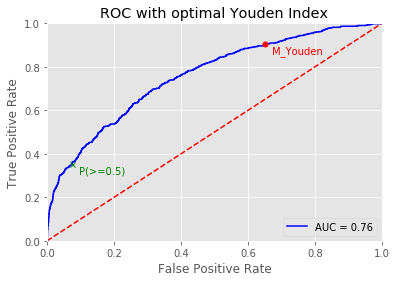


******* Using 0.5 Classification Threshold *******

[[1247  418]
 [ 233  374]]
the Accuracy is: 0.71
npv: 84.26
the classification_report:
               precision    recall  f1-score   support

         0.0       0.84      0.75      0.79      1665
         1.0       0.47      0.62      0.53       607

   micro avg       0.71      0.71      0.71      2272
   macro avg       0.66      0.68      0.66      2272
weighted avg       0.74      0.71      0.72      2272


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.13


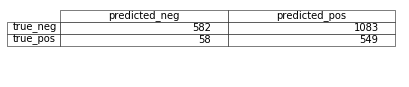

the Accuracy is: 0.50
npv: 90.94


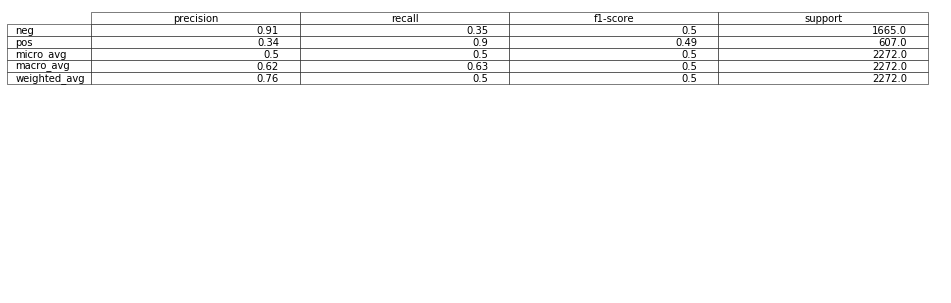

time: 1.32 s


In [140]:
svc_eval= classifier_eval(svc, x=np.array(x_test), y=y_test, save=False, model_name='svc', folder_name='clinical_agg_elix24')

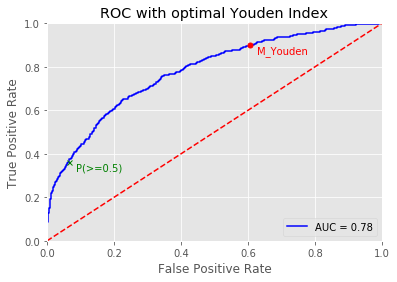


******* Using 0.5 Classification Threshold *******

[[1555  110]
 [ 384  223]]
the Accuracy is: 0.78
npv: 80.20
the classification_report:
               precision    recall  f1-score   support

         0.0       0.80      0.93      0.86      1665
         1.0       0.67      0.37      0.47       607

   micro avg       0.78      0.78      0.78      2272
   macro avg       0.74      0.65      0.67      2272
weighted avg       0.77      0.78      0.76      2272


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.13


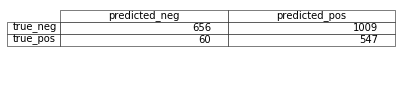

the Accuracy is: 0.53
npv: 91.62


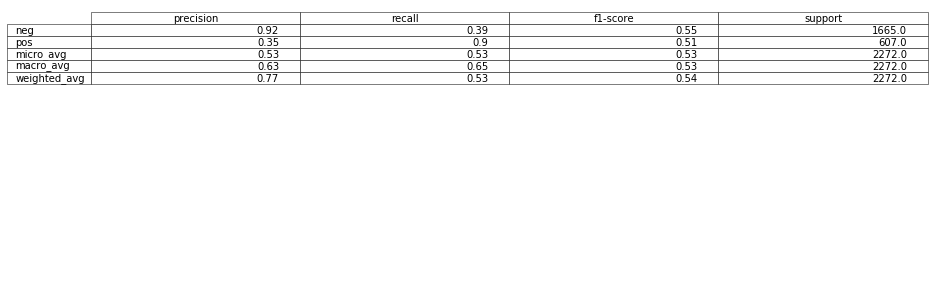

time: 497 ms


In [141]:
xgboost_eval= classifier_eval(xgboost, x=np.array(x_test), y=y_test, save=False, model_name='xgboost', folder_name='clinical_agg_elix24')

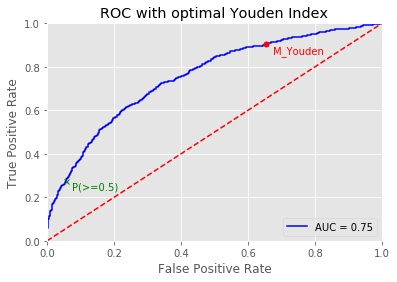


******* Using 0.5 Classification Threshold *******

[[1573   92]
 [ 442  165]]
the Accuracy is: 0.76
npv: 78.06
the classification_report:
               precision    recall  f1-score   support

         0.0       0.78      0.94      0.85      1665
         1.0       0.64      0.27      0.38       607

   micro avg       0.76      0.76      0.76      2272
   macro avg       0.71      0.61      0.62      2272
weighted avg       0.74      0.76      0.73      2272


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.14


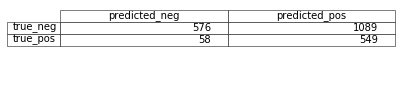

the Accuracy is: 0.50
npv: 90.85


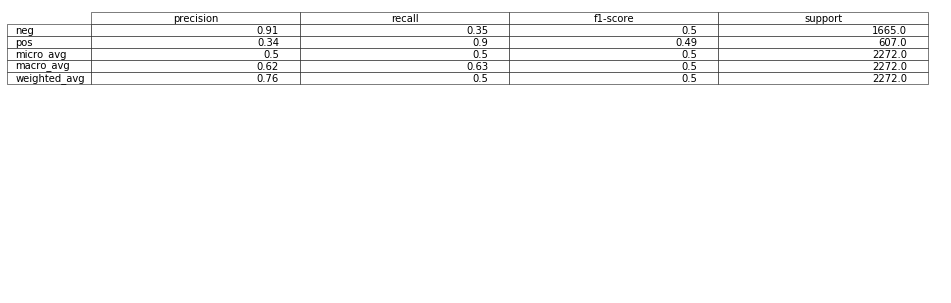

time: 486 ms


In [142]:
rf_eval= classifier_eval(rf, x=np.array(x_test), y=y_test, save=False, model_name='rf', folder_name='clinical_agg_elix24')

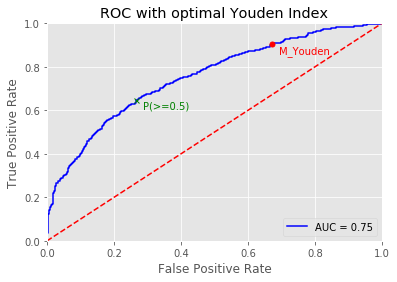


******* Using 0.5 Classification Threshold *******

[[1222  443]
 [ 215  392]]
the Accuracy is: 0.71
npv: 85.04
the classification_report:
               precision    recall  f1-score   support

         0.0       0.85      0.73      0.79      1665
         1.0       0.47      0.65      0.54       607

   micro avg       0.71      0.71      0.71      2272
   macro avg       0.66      0.69      0.67      2272
weighted avg       0.75      0.71      0.72      2272


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.27


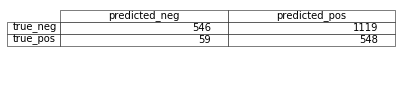

the Accuracy is: 0.48
npv: 90.25


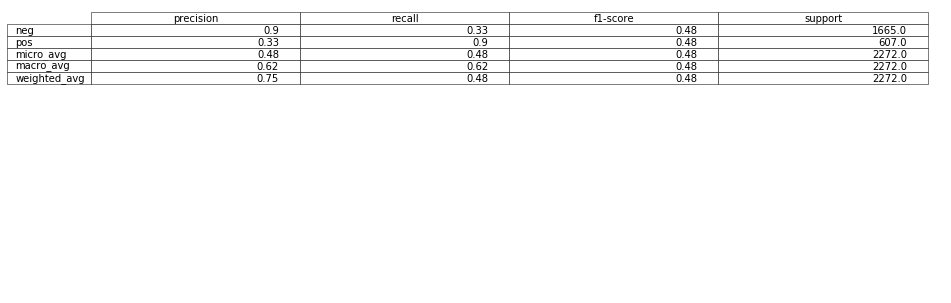

time: 505 ms


In [143]:
# logreg_eval= classifier_eval(logreg, x=np.array(x_test), y=y_test)
logreg_eval= classifier_eval(logreg, x=np.array(x_test), y=y_test, save=False, model_name='logreg', folder_name='clinical_agg_elix24')

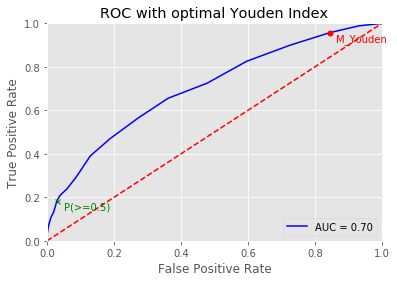


******* Using 0.5 Classification Threshold *******

[[1616   49]
 [ 495  112]]
the Accuracy is: 0.76
npv: 76.55
the classification_report:
               precision    recall  f1-score   support

         0.0       0.77      0.97      0.86      1665
         1.0       0.70      0.18      0.29       607

   micro avg       0.76      0.76      0.76      2272
   macro avg       0.73      0.58      0.57      2272
weighted avg       0.75      0.76      0.71      2272


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.08


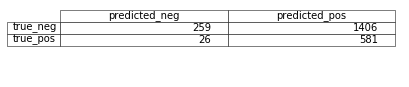

the Accuracy is: 0.37
npv: 90.88


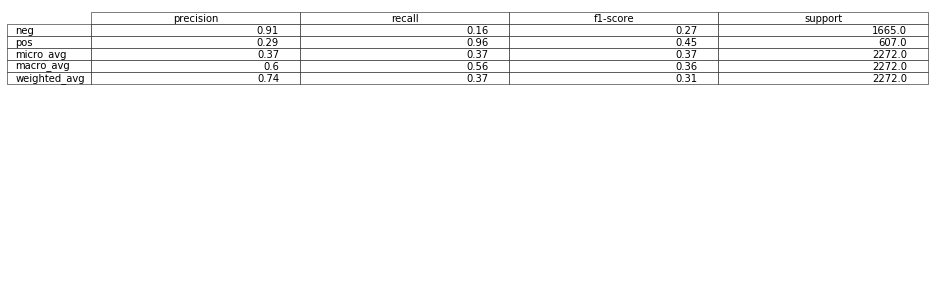

time: 2.05 s


In [144]:
knn_eval= classifier_eval(knn, x=np.array(x_test), y=y_test, save=False, model_name='knn', folder_name='clinical_agg_elix24')

## Ensemble of all models

In [145]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[("xgboost", xgboost), ('rf', rf), ('log_reg', logreg), ('svc',svc)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='soft', n_jobs=-1)
# If ‘hard’, uses predicted class labels for majority rule voting.
# Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities,
# which is recommended for an ensemble of well-calibrated classifiers.

#weights: array-like, shape (n_classifiers,), optional (default=`None`)
#Sequence of weights (float or int) to weight the occurrences of predicted class labels (hard voting) or class probabilities before averaging (soft voting).
#Uses uniform weights if None.
ensemble.fit(x, y)#, sample_weight=np.array([0.67289604, 1.94595562]))

VotingClassifier(estimators=[('xgboost', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

time: 8.61 s


In [146]:
# ensemble2 = VotingClassifier(estimators, voting='hard', n_jobs=-1)
# ensemble2.fit(x, y)

time: 734 µs


In [147]:
# y_pred = ensemble2.predict(np.array(x_test))
# #y_proba = ensemble2.predict_proba(np.array(x_test))[:,1]

time: 563 µs


In [148]:
# from sklearn import metrics
# from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
# pos_label=1
# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=pos_label)
# roc_auc = metrics.auc(fpr, tpr)

# #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
# youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)

# #plotting roc
# plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=False, model_name=ensemble2,folder_name=None, file_name='roc')
# plt.show(), plt.close()

# #printing npv, recall, precision, accuracy
# npv=confusion_matrix(y_test, y_pred)[0,0]/sum(np.array(y_pred)==0)*100
# prec= precision_score(y_true=y_test, y_pred= y_pred, pos_label=pos_label)*100
# recall= recall_score(y_true=y_test, y_pred= y_pred, pos_label=pos_label)*100
# f1= f1_score(y_true=y_test, y_pred= y_pred, pos_label=pos_label)*100
# acc=accuracy_score(y_test, y_pred)*100

# print("npv:", npv,'\n')
# print("prec:", prec,'\n')
# print("recall:", recall,'\n')
# print("f1:", f1,'\n')
# print("acc:", acc,'\n')

# hard_vote_summary={'model':"hard_voting_classifier",'auc':acc, 'precision':prec, 'recall':recall, 'f1':f1, 'npv':npv}

time: 3.7 ms


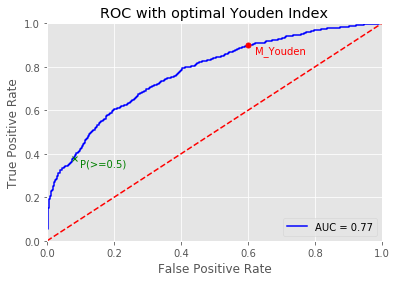


******* Using 0.5 Classification Threshold *******

[[1533  132]
 [ 375  232]]
the Accuracy is: 0.78
npv: 80.35
the classification_report:
               precision    recall  f1-score   support

         0.0       0.80      0.92      0.86      1665
         1.0       0.64      0.38      0.48       607

   micro avg       0.78      0.78      0.78      2272
   macro avg       0.72      0.65      0.67      2272
weighted avg       0.76      0.78      0.76      2272


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.19


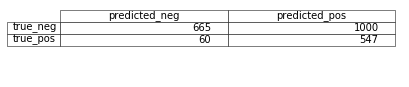

the Accuracy is: 0.53
npv: 91.72


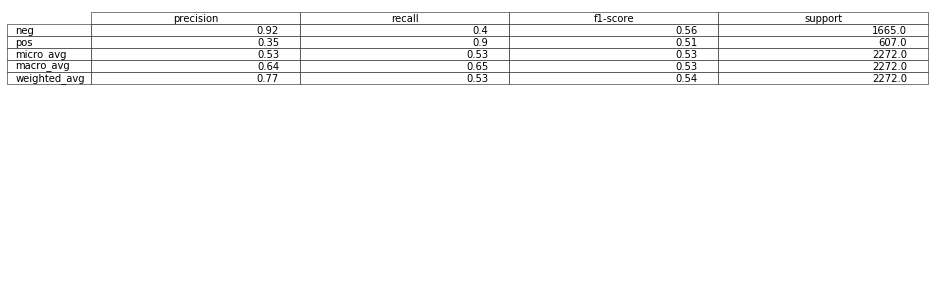

time: 1.76 s


In [149]:
ensemble_eval= classifier_eval(ensemble, x=np.array(x_test), y=y_test, save=True, model_name='model_ensemble', folder_name='clinical_agg_elix72')

In [150]:
np.unique(y)

array([0, 1])

time: 2.7 ms


In [151]:
from sklearn.utils.class_weight import compute_class_weight
compute_class_weight('balanced', np.unique(y), y)

array([0.68346619, 1.86264891])

time: 4.26 ms


In [152]:
#classifier_eval(gnb, x=x_test, y=y_test)
test_summary_df= pd.DataFrame([rf_eval,
                             logreg_eval,
                             xgboost_eval,
                             svc_eval,
                            ensemble_eval])
test_summary_df.set_index('model').round(decimals=2)

,auc,f1,npv,precision,recall
model,,,,,
RandomForestClassifier,75.44,48.91,90.85,33.52,90.44
LogisticRegression,75.30,48.20,90.25,32.87,90.28
XGBClassifier,77.89,50.58,91.62,35.15,90.12
SVC,75.74,49.04,90.94,33.64,90.44
VotingClassifier,77.40,50.79,91.72,35.36,90.12


time: 12.7 ms


# variable importance

In [96]:
def saveplot(figure_name,folder_name=None):
    """
    simple function for saving plots
    """
    if folder_name != None:
        address = 'figures/{}/'.format(folder_name)
    else:
        address = 'figures/'
    if not os.path.exists(address):
        os.makedirs(address)
    plt.savefig(address+"/{}.png".format(figure_name),bbox_inches='tight')

time: 4.96 ms


In [98]:
def var_imp(model,folder_name,model_name, n_var=4, save=True):
    model_name=type(model).__name__
    plot_title= "Top {} {} {} Variable Importance".format(n_var, folder_name,model_name)
    feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
    topn=feat_importances.nlargest(n_var).sort_values()
    ax=topn.plot(kind='barh', x='doop', title=plot_title)#.xlabel("xlab")
    ax.set_xlabel("Variable Importance")
    if save==True:
        saveplot(figure_name=plot_title, folder_name=folder_name)
    return(topn)

#     ###
#     imp= model.feature_importances_
#     var_index=[ x for x in range(0,len(rf.feature_importances_))]
#     variables=list(x_train)
#     return(pd.DataFrame({"imp":imp, 'index':var_index, 'variable': variables}).sort_values('imp', ascending=False))


time: 13.7 ms


In [ ]:
#var_imp(rf,plot_title='RF_' n_var=4)
#var_imp(rf,"clinical_agg","RF", n_var=6, save=False)

In [ ]:
var_imp(rf,"clinical_agg_elix","RF", n_var=20, save=True)

In [ ]:
#var_imp(xgboost2,"clinical_agg","xgboost", n_var=10, save=False)

meanartpress          0.030721
sysbp                 0.031730
heartrate             0.032266
nitrite_1.0           0.033829
resprate              0.035084
temperature           0.039951
leukocyte_1.0         0.040355
bicarbonate           0.048294
daily_sofa            0.078949
norepinephrine_1.0    0.201455
dtype: float32

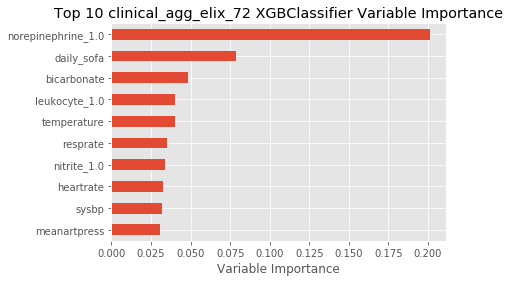

time: 332 ms


In [99]:
var_imp(xgboost,"clinical_agg_elix_72","xgboost", n_var=10, save=False)

In [ ]:
test_summary_df['model']

In [ ]:
print(len(x_train),len(x_test))

In [ ]:
len(x)

# model pickling

In [ ]:
import pickle
from sklearn import model_selection

# save the model to disk
model_list=[rf,logreg, xgboost,svc ]
for element in model_list:#test_summary_df['model']:
    filename = 'models/{}_{}_{}.sav'.format(date,dataset,type(element).__name__)
    #os.makedirs(os.path.dirname(filename), exist_ok=True)
    pickle.dump(element, open(filename, 'wb'))
    
    
# xgboost = reset_model('xgboost')
# xgboost.fit(x, y)

# logreg = reset_model('logreg')
# logreg.fit(x, y)

# rf= reset_model('rf')
# rf.fit(x,y)

# # from sklearn.naive_bayes import GaussianNB
# # gnb =GaussianNB()
# # nb_y_pred = gnb.fit(x, y)

# from sklearn import svm
# svc= reset_model('svc')
# svc.fit(x, y)

In [ ]:
#$dataset= "clinagg_elix"
filename
os.path.exists(filename)

In [ ]:
import pickle
from sklearn import model_selection

# save the model to disk
model_list=[rf,logreg, xgboost,svc ]
for element in model_list:#test_summary_df['model']:  
    filename = 'models/{}_{}_{}.sav'.format(date,dataset,type(element).__name__)
    pickle.dump(element, open(filename, 'wb'))


In [ ]:
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

# tSNE visualization
* 5-29-19 changes: changed x_full to x_train, ie dimension reduction will be performed on train set since grower samples will only come from train set (since all_xy is made from trainset)

In [101]:
from __future__ import print_function
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

time: 2.11 ms


In [179]:
def continuous_filter(df):   
     
    categorical=    ['phenylephrine_1.0',
     'norepinephrine_1.0',
     'vasopressin_1.0',
     'dobutamine_1.0',
     'dopamine_1.0',
     'epinephrine_1.0',
     'leukocyte_1.0',
     'nitrite_1.0',
     'vent_recieved_1.0',
     'vent_recieved_2.0',
     'o2_flow_1.0',
     'rrt_1.0',
     'cancer_elix_1.0',
     'any_vasoactives_1.0',
     'ethnicity_black',
     'ethnicity_hispanic',
     'ethnicity_unknown/other',
     'ethnicity_white/nonhispanic',
     'gender_1']
#     ['gender',
#      'ethnicity_black',
#      'ethnicity_hispanic',
#      'ethnicity_unknown/other',
#      'ethnicity_white/nonhispanic',
#      'ibands_absent',
#      'any_vasoactive_True',
#      'leukocyte_1',
#      'nitrite_1',
#      'pao2fio2ratio(200, 333]',
#      'pao2fio2ratio_(333, 475]',
#      'pao2fio2ratio_(475, 3000]',
#      'vent_recieved_1',
#      'vent_recieved_2',
#      'dobutamine_True',
#      'dopamine_True',
#      'epinephrine_True',
#      'norepinephrine_True',
#      'phenylephrine_True',
#      'rrt_True',
#      'vasopressin_True',
#      'ipco2_absent',
#      "cancer_elix_True"]

    
    df_list= list(df)
    in_both= list(set(categorical)& set(df_list))

    ##restricting all_xy to only continuous variables
    df = df.drop(columns=in_both)
    return(df)

time: 22 ms


In [163]:
def saveplot(figure_name,folder_name=None):
    """
    simple function for saving plots
    """
    if folder_name != None:
        address = 'figures/{}/'.format(folder_name)
    else:
        address = 'figures/'
    if not os.path.exists(address):
        os.makedirs(address)
    plt.savefig(address+"/{}.png".format(figure_name),bbox_inches='tight')
    #plt.close()

time: 4.7 ms


In [155]:
# dataprep
####### 5-29-19: changed this here for an easy fix and to realign the dimension reduction to be only on train data
#x_full=x_train.copy()#pd.concat([x_train,x_test]) 
#x_full=pd.concat([x_train,x_test]) 
icu_full= z_icustay_id.copy()#icu_full= pd.concat([z_icustay_id,z_icustay_id_test])
y_full=pd.DataFrame(y_train)#pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_test)])

time: 4.44 ms


In [178]:
list(x_train)

['bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'daily_sofa',
 'first_admit_age',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'potassium',
 'ptt',
 'resprate',
 'sum_elix',
 'temperature',
 'weight',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 'maxCalcium',
 'maxSodium',
 'maxWBC',
 'minCalcium',
 'minSodium',
 'minWBC',
 'phenylephrine_1.0',
 'norepinephrine_1.0',
 'vasopressin_1.0',
 'dobutamine_1.0',
 'dopamine_1.0',
 'epinephrine_1.0',
 'leukocyte_1.0',
 'nitrite_1.0',
 'vent_recieved_1.0',
 'vent_recieved_2.0',
 'o2_flow_1.0',
 'rrt_1.0',
 'cancer_elix_1.0',
 'any_vasoactives_1.0',
 'ethnicity_black',
 'ethnicity_hispanic',
 'ethnicity_unknown/other',
 'ethnicity_white/nonhispanic',
 'gender_1']

time: 2.26 ms


In [180]:
continuous_filter(x_train)

,bilirubin,bun,chloride,creatinine,daily_sofa,first_admit_age,glucose,heartrate,inr,lactate,...,ph,platelet,spo2,sysbp,maxCalcium,maxSodium,maxWBC,minCalcium,minSodium,minWBC
0,0.000000,0.073928,0.020529,0.000000,-0.178747,-0.055941,0.142015,0.127153,0.476541,0.203196,...,0.037494,-0.026237,-0.032201,-0.007495,0.082467,0.011917,0.127248,0.082467,0.007973,0.127248
1,0.000000,-0.096406,-0.008482,-0.234465,-0.430677,0.007956,0.132714,0.092040,-0.132111,-0.077558,...,0.124462,-0.110983,-0.006308,-0.017801,-0.294859,-0.004030,-0.186487,-0.424307,-0.012177,-0.186487
2,0.000000,0.013573,0.000000,0.070389,-0.430677,0.040770,-0.022911,0.127153,0.000000,0.072205,...,-0.050201,0.003187,-0.019120,-0.054090,0.123413,0.007973,0.039961,-0.209603,0.000000,-0.008412
3,1.528874,-0.181963,-0.012783,-0.074001,0.000000,-0.106253,0.191373,0.064284,0.000000,0.072205,...,-0.050201,-0.014414,-0.032201,0.028173,0.123413,-0.004030,0.178596,-0.209603,-0.004030,0.178596
4,0.000000,-0.136324,-0.004221,0.263034,0.347709,-0.168514,0.022596,0.081233,0.000000,-0.118605,...,0.025011,-0.050779,-0.045563,-0.088820,0.082467,-0.008089,-0.107093,-0.252128,-0.008089,-0.107093
5,0.960785,-0.265639,0.016498,-0.321928,0.138647,0.073689,-0.148695,0.064284,0.126488,0.072205,...,-0.050201,-0.124302,-0.012681,-0.072514,0.123413,0.004001,0.200965,-0.209603,-0.004030,0.200965
6,0.000000,-0.207491,-0.017126,-0.074001,0.138647,-0.000755,-0.035234,0.115063,0.000000,0.072205,...,0.037494,0.096376,-0.038846,-0.085484,0.325342,-0.012177,0.331501,0.325342,-0.012177,0.331501
7,1.012765,0.095198,0.020529,0.000000,0.251930,0.019222,0.098850,0.030582,0.364376,0.072205,...,0.087278,-0.191149,0.000000,-0.045302,0.000000,0.011917,-0.205373,0.000000,0.011917,-0.205373
8,0.000000,0.073928,-0.004221,-0.152003,-0.178747,0.036306,0.281488,0.143325,1.412966,-0.585671,...,-0.037628,0.084688,-0.073183,0.009700,0.123413,0.046215,-0.030117,-0.209603,0.015834,-0.030117
9,0.121387,-0.078177,-0.008482,0.000000,0.000000,0.012241,0.118617,0.099906,0.247811,0.072205,...,0.025011,-0.078673,-0.032201,-0.128309,0.404837,0.011917,0.107715,-0.555683,0.011917,0.107715


time: 50 ms


In [181]:
##PCA
from sklearn.decomposition import PCA

time_start = time.time()
pca = PCA(n_components=4)
#continuous_filter(x_train)
pca_result = pca.fit_transform(continuous_filter(x_train)) #x_train

print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])
pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print ('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

PCA done! Time elapsed: 0.016981124877929688 seconds
Variance explained per principal component: [0.27572217 0.18312883 0.13024501 0.09375888]
time: 34.3 ms


In [182]:
pca.explained_variance_ratio_[:2]

array([0.27572217, 0.18312883])

time: 2.16 ms


## PCA plot and grower labeling
* what is a good m value?
* do patients with different profiles: index 1 and 3457 differ in their grower samples on tsne?

In [ ]:
# m=50
# loc_sample=z_icustay_id[1]
# grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
# pca_df['y']= y_full.values

# ##added to color grower
# pd.DataFrame(pca_df)['icustay_id']=icu_full.values
# pca_df['grower']=pca_df['icustay_id'].isin(list(grower_samples))
# pca_df['sample']=pca_df['icustay_id']==(testing_sample_icu)

# pal = sns.dark_palette("palegreen", as_cmap=True)
# plt.figure(figsize=(16,10))
# # sns.scatterplot(x="pca1",
# #                 y="pca2",
# #                 hue='grower',
# #                 size='grower',
# #                 sizes=[25, 25],
# #                 style='y',
# #                 palette=sns.color_palette(n_colors=2, desat=0.9),
# #                 data=pca_df,
# #                 legend="full",
# #                 alpha=[0.8,0.6]
# # )

# ax= sns.scatterplot(x="pca1",
#                 y="pca2",
#                 data= pca_df[pca_df.grower==True],
#                 #hue='y',
# #                 size='grower',
# #                 sizes=[15, 50],
# #                 style='y',
#                 palette=sns.color_palette("Set2", n_colors=1, desat=.2),#sns.color_palette(sns.hls_palette(2, l=.3, s=.9)),#"hls",n_colors=2, desat=0.9),
#                 alpha=1,
#                 legend="full",
# #                 alpha=[0.8,0.6]
# )

# sns.scatterplot(x="pca1",
#                 y="pca2",
#                 data= pca_df[pca_df.grower==False],
#                 alpha=0.2,
#                 #hue='y',
#                 #palette=sns.color_palette(sns.color_palette("Set1", n_colors=2, desat=.9)),#sns.color_palette(sns.hls_palette(2, l=.5, s=.9)),#sns.color_palette("hls",n_colors=2, desat=0.8),
#                 legend='full',
#                 ax=ax)

# # sns.scatterplot(x="pca1",
# #                 y="pca2",
# #                 data= pca_df[pca_df.grower==False],
# #                 alpha=0.1,
# #                 hue='y',
# #                 palette=sns.color_palette(sns.color_palette("Set1", n_colors=2, desat=.9)),#sns.color_palette(sns.hls_palette(2, l=.5, s=.9)),#sns.color_palette("hls",n_colors=2, desat=0.8),
# #                 #legend='full',
# #                 ax=ax)

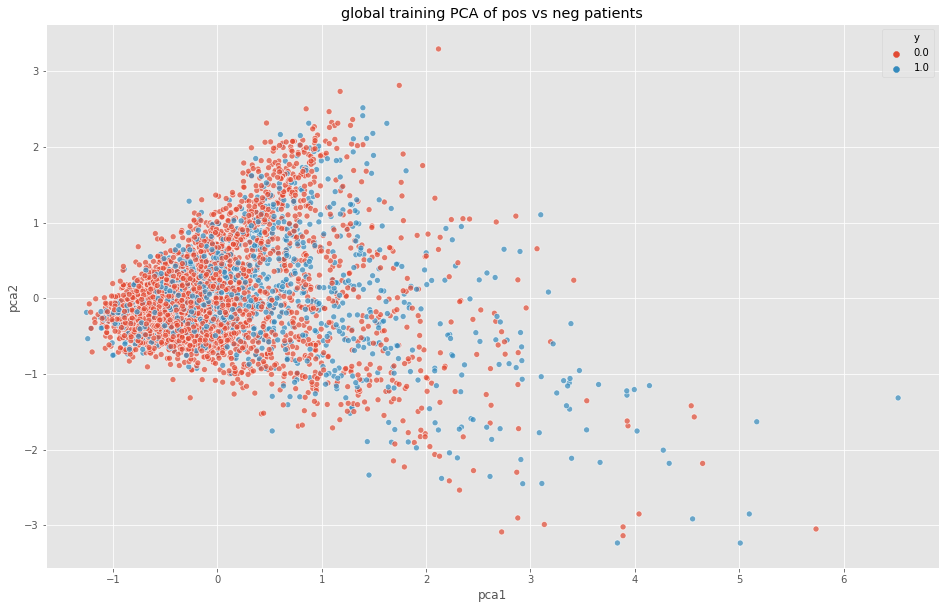

time: 1.06 s


In [183]:
pca_df['y']= y_full.values
plt.figure(figsize=(16,10))
ax=sns.scatterplot(x="pca1",
                y="pca2",
                hue='y',
                data= pca_df,#[pca_df.grower==False],
                alpha=0.7)

ax.set_title('global training PCA of pos vs neg patients')
saveplot(figure_name='global_training_PCA', folder_name='PCA')

In [186]:
def gower_distances(X, Y=None, w=None, categorical_features=None):
    """
    Computes the gower distances between X and Y

    Read more in the :ref:`User Guide <metrics>`.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)

    Y : array-like, shape (n_samples, n_features)

    w:  array-like, shape (n_features)
    According the Gower formula, w is an attribute weight.

    categorical_features: array-like, shape (n_features)
    Indicates with True/False wheter a column is a categorical attribute.
    This is useful when categorical atributes are represented as integer
    values.

    Returns
    -------
    similarities : ndarray, shape (n_samples, )

    Notes
    ------
    Gower is a similarity measure for categorical, boolean and numerical mixed
    data.

    """

    X, Y = check_pairwise_arrays(X, Y, dtype=(np.object, None)[issparse(X) or
                                                               issparse(Y)])
    rows, cols = X.shape

    if categorical_features is None:
        categorical_features = []
        for col in range(cols):
            if np.issubdtype(type(X[0, col]), np.number):
                categorical_features.append(False)
            else:
                categorical_features.append(True)
    # Calculates the normalized ranges and max values of numeric values
    ranges_of_numeric = [0.0] * cols
    max_of_numeric = [0.0] * cols
    for col in range(cols):
        if not categorical_features[col]:
            max = None
            min = None
            if issparse(X):
                col_array = X.getcol(col)
                max = col_array.max() + 0.0
                min = col_array.min() + 0.0
            else:
                col_array = X[:, col].astype(np.double)
                max = np.nanmax(col_array)
                min = np.nanmin(col_array)

            if np.isnan(max):
                max = 0.0
            if np.isnan(min):
                min = 0.0
            max_of_numeric[col] = max
            ranges_of_numeric[col] = (1 - min / max) if (max != 0) else 0.0

    if w is None:
        w = [1] * cols

    yrows, ycols = Y.shape

    dm = np.zeros((rows, yrows), dtype=np.double)

    for i in range(0, rows):
        j_start = i

        # for non square results
        if rows != yrows:
            j_start = 0

        for j in range(j_start, yrows):
            sum_sij = 0.0
            sum_wij = 0.0
            for col in range(cols):
                value_xi = X[i, col]
                value_xj = Y[j, col]

                if not categorical_features[col]:
                    if (max_of_numeric[col] != 0):
                        value_xi = value_xi / max_of_numeric[col]
                        value_xj = value_xj / max_of_numeric[col]
                    else:
                        value_xi = 0
                        value_xj = 0

                    if ranges_of_numeric[col] != 0:
                        sij = abs(value_xi - value_xj) / ranges_of_numeric[col]
                    else:
                        sij = 0
                    wij = (w[col], 0)[np.isnan(value_xi) or np.isnan(value_xj)]
                else:
                    sij = (1.0, 0.0)[value_xi == value_xj]
                    wij = (w[col], 0)[value_xi is None and value_xj is None]
                sum_sij += (wij * sij)
                sum_wij += wij

            if sum_wij != 0:
                dm[i, j] = (sum_sij / sum_wij)
                if j < rows and i < yrows:
                    dm[j, i] = dm[i, j]
    return dm

def select_train_samples(sample_id, all_xy, m, time_interval):# m is number of similar cases or controls
    num_control = m   # the ratio of case and control is 1:2, 1:3,1:4
    
    ####not sure what this is doing.
    if time_interval == 24:
        top_con_variables = [False]*128
        mid_cat_variables = [True]*5
        age_variable = [False]
        next_cat_variables = [True]*10
        last_con_variables = [False]*2

        flag_cate_fea = top_con_variables + mid_cat_variables + age_variable + next_cat_variables + last_con_variables # 24,48, ...., Note that, the length of 24h  is different from other hours  in terms of columns
    else:
        top_con_variables = [False]*129  #there is another item in other hours
        mid_cat_variables = [True]*5
        age_variable = [False]
        next_cat_variables = [True]*10
        last_con_variables = [False]*2

        flag_cate_fea = top_con_variables + mid_cat_variables + age_variable + next_cat_variables + last_con_variables # 24,48, ...., Note that, the length of 24h  is different from other hours  in terms of columns
        
    ##all_xy = all_xy.fillna(np.nan) # fill empty with nan

    x_candidate_label = all_xy.loc[sample_id] # get the object sample
    x_candidate = x_candidate_label.drop('label')
    x_candidate_tem = x_candidate.as_matrix()
    testing_sample = x_candidate_tem.reshape(1, -1)  # covert into ....

    all_x_candidate_tem = all_xy.drop([sample_id], axis=0, inplace=False) # delete the object sample from whole set

# select similar cases
    all_cases = all_x_candidate_tem[all_x_candidate_tem.label == 1]
    all_cases_candidate = all_cases.drop(['label'], axis=1, inplace=False)
    gower_candidate_case = all_cases_candidate.values[:, :] # convert into ndarray

    Gower_Distance_1 = gower_distances(gower_candidate_case, testing_sample, categorical_features = flag_cate_fea) # Gower_Distance_1 is ndarray
    Gower_Distance_2 = list(Gower_Distance_1)
    Gower_Distance_3 = pd.Series(Gower_Distance_2, index = all_cases_candidate.index)
    Gower_Distance_4 = Gower_Distance_3.sort_values(ascending=False)

    Id_selected_cases = Gower_Distance_4.index[:m].tolist() # the id set of the top m similar samples

# select similar controls
    all_controls = all_x_candidate_tem[all_x_candidate_tem.label == 0]
    all_controls_candidate = all_controls.drop(['label'], axis=1, inplace=False)
    gower_candidate_control = all_controls_candidate.values[:, :] # convert into ndarray

    Gower_Distance_11 = gower_distances(gower_candidate_control, testing_sample,categorical_features = flag_cate_fea) # Gower_Distance_1 is ndarray
    Gower_Distance_22 = list(Gower_Distance_11)
    Gower_Distance_33 = pd.Series(Gower_Distance_22, index = all_controls_candidate.index)
    Gower_Distance_44 = Gower_Distance_33.sort_values(ascending=False)

    Id_selected_controls = Gower_Distance_44.index[:num_control].tolist() # the id set of the top m similar samples

    train_set_id = Id_selected_controls+Id_selected_cases

    train_set_id = np.array(train_set_id)
    return train_set_id

time: 684 ms


In [200]:
def m_distance_samples(sample_id, all_xy, m, time_interval,metric='euclidean'):# m is number of similar cases or controls
    """
    GE created, will only look at continuous variables and will find the m closest euclidian distanced rows for y==0 and y==1. 
    """
    import scipy
    from scipy.spatial.distance import squareform

    ##restricting all_xy to only continuous variables
    all_xy_cont = continuous_filter(all_xy)

    ##calculating euclidian distance matrix
    res = scipy.spatial.distance.pdist(all_xy_cont.iloc[:,:-1], metric)
    euc_df=pd.DataFrame(squareform(res), index=all_xy_cont.index, columns= all_xy_cont.index)

    ##df of label and icustay_id. 
    icu_label=all_xy_cont.reset_index()[['final_bin','icustay_id']]
    
    ##y==1 samples
    t_icu=list(icu_label[icu_label['final_bin']==1]['icustay_id'])
    if loc_sample in t_icu:
        t_icu.remove(sample_id)
    m_samples_true = euc_df.loc[t_icu,sample_id].sort_values(ascending=True)
    m_samples_true = m_samples_true.head(m).reset_index()['icustay_id']    
    
    ##y==0 samples    
    f_icu=list(icu_label[icu_label['final_bin']==0]['icustay_id'])
    if loc_sample in f_icu:
        f_icu.remove(sample_id)
    m_samples_false = euc_df.loc[f_icu,sample_id].sort_values(ascending=True)
    m_samples_false = m_samples_false.head(m).reset_index()['icustay_id']
    
    ## all m y==0 and y==1 samples
    all_m_samples= list(m_samples_true) + list(m_samples_false)
    
    return all_m_samples

time: 38.4 ms


In [203]:
train_data

,icustay_id,bilirubin,bun,chloride,creatinine,daily_sofa,first_admit_age,glucose,heartrate,inr,...,vent_recieved_2.0,o2_flow_1.0,rrt_1.0,cancer_elix_1.0,any_vasoactives_1.0,ethnicity_black,ethnicity_hispanic,ethnicity_unknown/other,ethnicity_white/nonhispanic,gender_1
0,200030.0,0.000000,0.073928,0.020529,0.000000,-0.178747,-0.055941,0.142015,0.127153,0.476541,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,200033.0,0.000000,-0.096406,-0.008482,-0.234465,-0.430677,0.007956,0.132714,0.092040,-0.132111,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
2,200036.0,0.000000,0.013573,0.000000,0.070389,-0.430677,0.040770,-0.022911,0.127153,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,200061.0,1.528874,-0.181963,-0.012783,-0.074001,0.000000,-0.106253,0.191373,0.064284,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,200063.0,0.000000,-0.136324,-0.004221,0.263034,0.347709,-0.168514,0.022596,0.081233,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,200075.0,0.960785,-0.265639,0.016498,-0.321928,0.138647,0.073689,-0.148695,0.064284,0.126488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,200078.0,0.000000,-0.207491,-0.017126,-0.074001,0.138647,-0.000755,-0.035234,0.115063,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
7,200091.0,1.012765,0.095198,0.020529,0.000000,0.251930,0.019222,0.098850,0.030582,0.364376,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,200108.0,0.000000,0.073928,-0.004221,-0.152003,-0.178747,0.036306,0.281488,0.143325,1.412966,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,200136.0,0.121387,-0.078177,-0.008482,0.000000,0.000000,0.012241,0.118617,0.099906,0.247811,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


time: 58.8 ms


In [ ]:
# ## pcaplot and grower labeling  [different style]
# m=100
# loc_sample=z_icustay_id[3457]
# grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
# pca_df['y']= y_full.values

# ##added to color grower
# pd.DataFrame(pca_df)['icustay_id']=icu_full.values
# pca_df['grower']=pca_df['icustay_id'].isin(list(grower_samples))
# pca_df['sample']=pca_df['icustay_id']==(testing_sample_icu)

# plt.figure(figsize=(16,10))
# sns.scatterplot(x="pca1",
#                 y="pca2",
#                 hue='grower',
#                 size='grower',
#                 sizes=[15, 80],
#                 #style='grower',
#                 #palette=sns.color_palette("hls", 2),
#                 data=pca_df,
#                 legend="full",
#                 alpha=0.6
# )

# ax.set_title('PCA of m={} gower closest ICU stay vs rest for icu_index={}'.format(m,index))
# ax.set(xlabel='PCA1 ({:.2f}% variance)'.format(pca.explained_variance_ratio_[:1][0]), ylabel='PCA2({:.2f}% variance)'.format(pca.explained_variance_ratio_[1:2][0]))
# saveplot(figure_name='local_training_PCA_m{}_icu{}'.format(m,index), folder_name='tsne')

## pcaplot and grower labeling

In [206]:
z_icustay_id_test

0       200012.0
1       200014.0
2       200055.0
3       200059.0
4       200116.0
5       200150.0
6       200250.0
7       200269.0
8       200349.0
9       200350.0
10      200357.0
11      200361.0
12      200399.0
13      200450.0
14      200474.0
15      200477.0
16      200489.0
17      200492.0
18      200550.0
19      200642.0
20      200660.0
21      200664.0
22      200744.0
23      200745.0
24      200805.0
25      200824.0
26      200918.0
27      200924.0
28      200946.0
29      200957.0
          ...   
2242    298772.0
2243    298859.0
2244    298909.0
2245    298923.0
2246    298955.0
2247    299008.0
2248    299033.0
2249    299051.0
2250    299079.0
2251    299125.0
2252    299180.0
2253    299187.0
2254    299216.0
2255    299319.0
2256    299336.0
2257    299389.0
2258    299394.0
2259    299490.0
2260    299495.0
2261    299554.0
2262    299662.0
2263    299800.0
2264    299806.0
2265    299828.0
2266    299832.0
2267    299888.0
2268    299903.0
2269    299917

time: 4.12 ms


In [193]:
## pcaplot and grower labeling
m=100
index=3
loc_sample=z_icustay_id[index]
grower_samples=select_train_samples(loc_sample, train_data, m, time_interval)
pca_df['y']= y_full.values

##added to color grower
pd.DataFrame(pca_df)['icustay_id']=icu_full.values
pca_df['grower']=pca_df['icustay_id'].isin(list(grower_samples))
pca_df['sample']=pca_df['icustay_id']==(testing_sample_icu)

plt.figure(figsize=(16,10))
ax=sns.scatterplot(x="pca1",
                y="pca2",
                data=pca_df[pca_df.grower==True],
                style="y",
                size="y",
                sizes=[80,80],
                palette=sns.color_palette("Set2", n_colors=1, desat=.2),#sns.color_palette(sns.hls_palette(2, l=.3, s=.9)),#"hls",n_colors=2, desat=0.9),
                alpha=1,
                legend="full"
)
sns.scatterplot(x="pca1",
                y="pca2",
                data=pca_df[pca_df.grower==False],
                alpha=0.2,
                style="y",
                #hue='y',
                #palette=sns.color_palette(sns.color_palette("Set1", n_colors=2, desat=.9)),#sns.color_palette(sns.hls_palette(2, l=.5, s=.9)),#sns.color_palette("hls",n_colors=2, desat=0.8),
                legend='full',
                ax=ax)

ax.set_title('PCA of m={} gower closest ICU stay vs rest for icu_index={}'.format(m,index))
ax.set(xlabel='PCA1 ({:.2f}% variance)'.format(pca.explained_variance_ratio_[:1][0]), ylabel='PCA2({:.2f}% variance)'.format(pca.explained_variance_ratio_[1:2][0]))

#saveplot(figure_name='local_training_PCA_m{}_icu{}'.format(m,index), folder_name='PCA')

KeyError: 200061

time: 97.2 ms


In [ ]:
## pcaplot and grower labeling
m=100
index=3457
loc_sample=z_icustay_id[index]
grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
pca_df['y']= y_full.values

##added to color grower
pd.DataFrame(pca_df)['icustay_id']=icu_full.values
pca_df['grower']=pca_df['icustay_id'].isin(list(grower_samples))
#pca_df['sample']=pca_df['icustay_id']==(testing_sample_icu)


plt.figure(figsize=(16,10))
ax=sns.scatterplot(x="pca1",
                y="pca2",
                data=pca_df[pca_df.grower==True],
                style="y",
                size="y",
                sizes=[80,80],
                palette=sns.color_palette("Set2", n_colors=1, desat=.2),#sns.color_palette(sns.hls_palette(2, l=.3, s=.9)),#"hls",n_colors=2, desat=0.9),
                alpha=1,
                legend="full"
)

sns.scatterplot(x="pca1",
                y="pca2",
                data=pca_df[pca_df.grower==False],
                alpha=0.2,
                style="y",
                #hue='y',
                #palette=sns.color_palette(sns.color_palette("Set1", n_colors=2, desat=.9)),#sns.color_palette(sns.hls_palette(2, l=.5, s=.9)),#sns.color_palette("hls",n_colors=2, desat=0.8),
                legend='full',
                ax=ax)

ax.set_title('PCA of m={} gower closest ICU stay vs rest for icu_index={}'.format(m,index))
ax.set(xlabel='PCA1 ({:.2f}% variance)'.format(pca.explained_variance_ratio_[:1][0]), ylabel='PCA2({:.2f}% variance)'.format(pca.explained_variance_ratio_[1:2][0]))

saveplot(figure_name='local_training_PCA_m{}_icu{}_allcont'.format(m,index), folder_name='PCA')

In [207]:
## pcaplot and grower labeling
m=100
index=3457
loc_sample=200012.0#z_icustay_id[index]
euc_samples=m_distance_samples(loc_sample, train_data, m, time_interval, metric='euclidean')
pca_df['y']= y_full.values


##added to color grower
pd.DataFrame(pca_df)['icustay_id']=icu_full.values
pca_df['euc']=pca_df['icustay_id'].isin(list(euc_samples))

plt.figure(figsize=(16,10))
ax=sns.scatterplot(x="pca1",
                y="pca2",
                data=pca_df[pca_df.euc==True],
                style="y",
                size="y",
                sizes=[80,80],
                palette=sns.color_palette("Set2", n_colors=1, desat=.2),#sns.color_palette(sns.hls_palette(2, l=.3, s=.9)),#"hls",n_colors=2, desat=0.9),
                alpha=1,
                legend="full"
)

sns.scatterplot(x="pca1",
                y="pca2",
                data=pca_df[pca_df.euc==False],
                alpha=0.1,
                style="y",
                #hue='y',
                #palette=sns.color_palette(sns.color_palette("Set1", n_colors=2, desat=.9)),#sns.color_palette(sns.hls_palette(2, l=.5, s=.9)),#sns.color_palette("hls",n_colors=2, desat=0.8),
                legend='full',
                ax=ax)

ax1.set_title('PCA of m={} gower closest ICU stay vs rest for icu_index={}'.format(m,index))
ax1.set(xlabel='PCA1 ({:.2f}% variance)'.format(pca.explained_variance_ratio_[:1][0]), ylabel='PCA2({:.2f}% variance)'.format(pca.explained_variance_ratio_[1:2][0]))

saveplot(figure_name='euc_training_PCA_m{}_icu{}_allcont'.format(m,index), folder_name='PCA')


KeyError: 200012

time: 857 ms


## tSNE plot and grower labeling
* what is a good m value?
* do patients with different profiles: index 1 and 3457 differ in their grower samples on tsne?

In [208]:
##TSNE fit, run once
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(continuous_filter(x_train))#x_full)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5316 samples in 0.018s...
[t-SNE] Computed neighbors for 5316 samples in 1.256s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5316
[t-SNE] Computed conditional probabilities for sample 2000 / 5316
[t-SNE] Computed conditional probabilities for sample 3000 / 5316
[t-SNE] Computed conditional probabilities for sample 4000 / 5316
[t-SNE] Computed conditional probabilities for sample 5000 / 5316
[t-SNE] Computed conditional probabilities for sample 5316 / 5316
[t-SNE] Mean sigma: 0.287804
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.932549
[t-SNE] KL divergence after 500 iterations: 1.773136
t-SNE done! Time elapsed: 29.058167695999146 seconds
time: 29.1 s


Text(0.5, 1.0, 'global training t-SNE of pos vs neg patients')

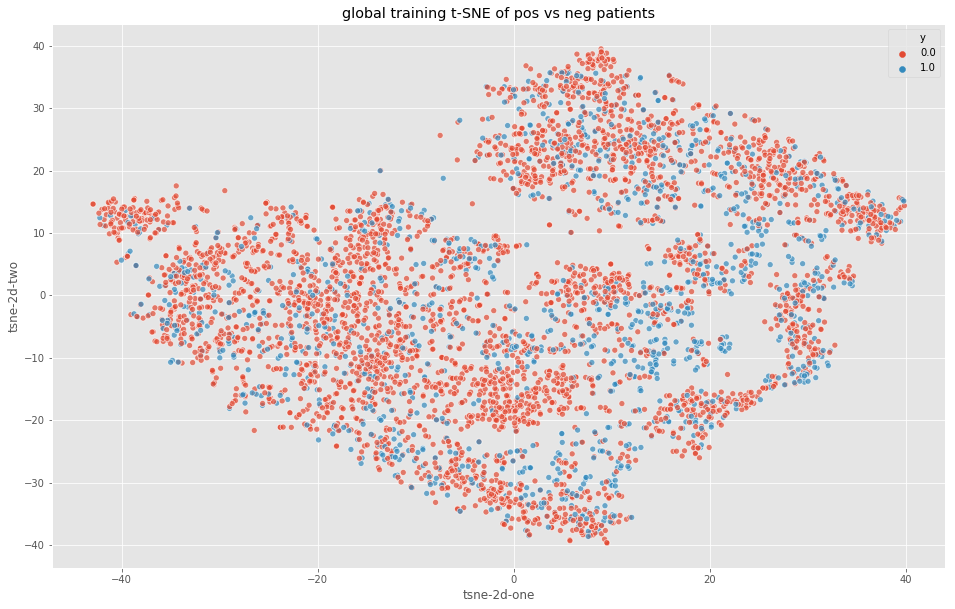

time: 735 ms


In [209]:
##plotting all trainset labeling y==true, y==false. 
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['y']= y_full.values

plt.figure(figsize=(16,10))
ax= sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                hue='y',
                data=tsne_df,
                legend="full",
                alpha=0.7
)

ax.set_title('global training t-SNE of pos vs neg patients')

#saveplot(figure_name='global_training_tsne', folder_name='tsne')

In [ ]:
#m=100 tsne w patient at index 1: a y=0 patient and gender=1
m=100
index=1
loc_sample=z_icustay_id[index]
grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['y']= y_full.values
##added to color grower
pd.DataFrame(tsne_df)['icustay_id']=icu_full.values
tsne_df['grower']=tsne_df['icustay_id'].isin(list(grower_samples))
tsne_df['sample']=tsne_df['icustay_id']==(loc_sample)

plt.figure(figsize=(16,10))
ax=sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.grower==True],
                style="y",
                size="y",
                sizes=[80,80],
                palette=sns.color_palette("Set2", n_colors=1, desat=.2),#sns.color_palette(sns.hls_palette(2, l=.3, s=.9)),#"hls",n_colors=2, desat=0.9),
                alpha=1,
                legend="full"
)

sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.grower==False],
                alpha=0.2,
                #hue='y',
                #palette=sns.color_palette(sns.color_palette("Set1", n_colors=2, desat=.9)),#sns.color_palette(sns.hls_palette(2, l=.5, s=.9)),#sns.color_palette("hls",n_colors=2, desat=0.8),
                legend='full',
                ax=ax)

ax.set_title('t-SNE of m={} gower closest ICU stay vs rest for icu_index={}'.format(m,index))

#saveplot(figure_name='local_training_tsne_m{}_icu{}'.format(m,index), folder_name='tsne')


In [ ]:
#m=100 tsne w patient at index 3457: a y=1 patient and gender=0
m=100
index=3457
loc_sample=z_icustay_id[index]
grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['y']= y_full.values
##added to color grower
pd.DataFrame(tsne_df)['icustay_id']=icu_full.values
tsne_df['grower']=tsne_df['icustay_id'].isin(list(grower_samples))
tsne_df['sample']=tsne_df['icustay_id']==(loc_sample)

plt.figure(figsize=(16,10))
ax=sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.grower==True],
                style="y",
                size="y",
                sizes=[80,80],
                palette=sns.color_palette("Set2", n_colors=1, desat=.2),#sns.color_palette(sns.hls_palette(2, l=.3, s=.9)),#"hls",n_colors=2, desat=0.9),
                alpha=1,
                legend="full"
)

sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.grower==False],
                alpha=0.2,
                #hue='y',
                #palette=sns.color_palette(sns.color_palette("Set1", n_colors=2, desat=.9)),#sns.color_palette(sns.hls_palette(2, l=.5, s=.9)),#sns.color_palette("hls",n_colors=2, desat=0.8),
                legend='full',
                ax=ax)

ax.set_title('t-SNE of m={} gower closest ICU stay vs rest for icu_index={}'.format(m,index))
#saveplot(figure_name='local_training_tsne_m{}_icu{}'.format(m,index), folder_name='tsne')



In [ ]:
#####duplcicate plot with different style
#m=100 tsne w patient at index 3457: a y=1 patient and gender=0
# m=100
# loc_sample=z_icustay_id[3457]
# grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)

# tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
# tsne_df['tsne-2d-one'] = tsne_results[:,0]
# tsne_df['tsne-2d-two'] = tsne_results[:,1]
# tsne_df['y']= y_full.values
# ##added to color grower
# pd.DataFrame(tsne_df)['icustay_id']=icu_full.values
# tsne_df['grower']=tsne_df['icustay_id'].isin(list(grower_samples))
# tsne_df['sample']=tsne_df['icustay_id']==(loc_sample)
# plt.figure(figsize=(16,10))
# sns.scatterplot(x="tsne-2d-one",
#                 y="tsne-2d-two",
#                 hue='grower',
#                 size='grower',
#                 sizes=[30, 100],
#                 style='y',
#                 #palette=sns.color_palette("hls", 2),
#                 data=tsne_df,
#                 legend="full",
#                 alpha=0.7
# )



In [ ]:
#m=250 tsne w patient at index 1 
m=250
index=1
loc_sample=z_icustay_id[index]
grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['y']= y_full.values
##added to color grower
pd.DataFrame(tsne_df)['icustay_id']=icu_full.values
tsne_df['grower']=tsne_df['icustay_id'].isin(list(grower_samples))
tsne_df['sample']=tsne_df['icustay_id']==(loc_sample)

plt.figure(figsize=(16,10))
ax=sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.grower==True],
                style="y",
                size="y",
                sizes=[80,80],
                palette=sns.color_palette("Set2", n_colors=1, desat=.2),#sns.color_palette(sns.hls_palette(2, l=.3, s=.9)),#"hls",n_colors=2, desat=0.9),
                alpha=1,
                legend="full"
)

sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.grower==False],
                alpha=0.2,
                #hue='y',
                #palette=sns.color_palette(sns.color_palette("Set1", n_colors=2, desat=.9)),#sns.color_palette(sns.hls_palette(2, l=.5, s=.9)),#sns.color_palette("hls",n_colors=2, desat=0.8),
                legend='full',
                ax=ax)

ax.set_title('t-SNE of m={} gower closest ICU stay vs rest for icu_index={}'.format(m,index))
saveplot(figure_name='gower_local_training_tsne_m{}_icu{}'.format(m,index), folder_name='tsne')

In [ ]:
#m=250 tsne w patient at index 3457
m=250
index=3457
loc_sample=z_icustay_id[index]
grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['y']= y_full.values
##added to color grower
pd.DataFrame(tsne_df)['icustay_id']=icu_full.values
tsne_df['grower']=tsne_df['icustay_id'].isin(list(grower_samples))
tsne_df['sample']=tsne_df['icustay_id']==(loc_sample)

plt.figure(figsize=(16,10))
ax=sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.grower==True],
                style="y",
                size="y",
                sizes=[80,80],
                palette=sns.color_palette("Set2", n_colors=1, desat=.2),#sns.color_palette(sns.hls_palette(2, l=.3, s=.9)),#"hls",n_colors=2, desat=0.9),
                alpha=1,
                legend="full"
)

sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.grower==False],
                alpha=0.2,
                #hue='y',
                #palette=sns.color_palette(sns.color_palette("Set1", n_colors=2, desat=.9)),#sns.color_palette(sns.hls_palette(2, l=.5, s=.9)),#sns.color_palette("hls",n_colors=2, desat=0.8),
                legend='full',
                ax=ax)

ax.set_title('t-SNE of m={} gower closest ICU stay vs rest for icu_index={}'.format(m,index))
saveplot(figure_name='gower_local_training_tsne_m{}_icu{}'.format(m,index), folder_name='tsne')

In [ ]:
#m=50 tsne w patient at index 1
m=50
index=1
loc_sample=z_icustay_id[index]
grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['y']= y_full.values
##added to color grower
pd.DataFrame(tsne_df)['icustay_id']=icu_full.values
tsne_df['grower']=tsne_df['icustay_id'].isin(list(grower_samples))
tsne_df['sample']=tsne_df['icustay_id']==(loc_sample)

plt.figure(figsize=(16,10))
ax=sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.grower==True],
                style="y",
                size="y",
                sizes=[80,80],
                palette=sns.color_palette("Set2", n_colors=1, desat=.2),#sns.color_palette(sns.hls_palette(2, l=.3, s=.9)),#"hls",n_colors=2, desat=0.9),
                alpha=1,
                legend="full"
)

sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.grower==False],
                alpha=0.2,
                #hue='y',
                #palette=sns.color_palette(sns.color_palette("Set1", n_colors=2, desat=.9)),#sns.color_palette(sns.hls_palette(2, l=.5, s=.9)),#sns.color_palette("hls",n_colors=2, desat=0.8),
                legend='full',
                ax=ax)

ax.set_title('t-SNE of m={} gower closest ICU stay vs rest for icu_index={}'.format(m,index))
saveplot(figure_name='gower_local_training_tsne_m{}_icu{}'.format(m,index), folder_name='tsne')

In [ ]:
#m=50 tsne w patient at index 3457
m=50
index=3457
loc_sample=z_icustay_id[index]
grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['y']= y_full.values
##added to color grower
pd.DataFrame(tsne_df)['icustay_id']=icu_full.values
tsne_df['grower']=tsne_df['icustay_id'].isin(list(grower_samples))
tsne_df['sample']=tsne_df['icustay_id']==(loc_sample)

plt.figure(figsize=(16,10))
ax=sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.grower==True],
                style="y",
                size="y",
                sizes=[80,80],
                palette=sns.color_palette("Set2", n_colors=1, desat=.2),#sns.color_palette(sns.hls_palette(2, l=.3, s=.9)),#"hls",n_colors=2, desat=0.9),
                alpha=1,
                legend="full"
)

sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.grower==False],
                alpha=0.2,
                #hue='y',
                #palette=sns.color_palette(sns.color_palette("Set1", n_colors=2, desat=.9)),#sns.color_palette(sns.hls_palette(2, l=.5, s=.9)),#sns.color_palette("hls",n_colors=2, desat=0.8),
                legend='full',
                ax=ax)

ax.set_title('t-SNE of m={} gower closest ICU stay vs rest for icu_index={}'.format(m,index))
saveplot(figure_name='gower_local_training_tsne_m{}_icu{}'.format(m,index), folder_name='tsne')

In [ ]:
## pcaplot and euclidean labeling
m=100
index=1
loc_sample=z_icustay_id[index]
euc_samples=m_distance_samples(loc_sample, all_xy, m, time_interval, metric='euclidean')

#grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['y']= y_full.values
##added to color grower
pd.DataFrame(tsne_df)['icustay_id']=icu_full.values
tsne_df['euc']=tsne_df['icustay_id'].isin(list(euc_samples))

plt.figure(figsize=(16,10))
ax=sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.euc==True],
                style="y",
                size="y",
                sizes=[80,80],
                palette=sns.color_palette("Set2", n_colors=1, desat=.2),#sns.color_palette(sns.hls_palette(2, l=.3, s=.9)),#"hls",n_colors=2, desat=0.9),
                alpha=1,
                legend="full"
)

sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.euc==False],
                alpha=0.2,
                #hue='y',
                #palette=sns.color_palette(sns.color_palette("Set1", n_colors=2, desat=.9)),#sns.color_palette(sns.hls_palette(2, l=.5, s=.9)),#sns.color_palette("hls",n_colors=2, desat=0.8),
                legend='full',
                ax=ax)

ax.set_title('t-SNE of m={} gower closest ICU stay vs rest for icu_index={}'.format(m,index))
saveplot(figure_name='euc_local_training_tsne_m{}_icu{}'.format(m,index), folder_name='tsne')

In [ ]:
## pcaplot and euclidean labeling
m=100
index=3457
loc_sample=z_icustay_id[index]
euc_samples=m_distance_samples(loc_sample, all_xy, m, time_interval, metric='euclidean')

#grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['y']= y_full.values
##added to color grower
pd.DataFrame(tsne_df)['icustay_id']=icu_full.values
tsne_df['euc']=tsne_df['icustay_id'].isin(list(euc_samples))

plt.figure(figsize=(16,10))
ax=sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.euc==True],
                style="y",
                size="y",
                sizes=[80,80],
                palette=sns.color_palette("Set2", n_colors=1, desat=.2),#sns.color_palette(sns.hls_palette(2, l=.3, s=.9)),#"hls",n_colors=2, desat=0.9),
                alpha=1,
                legend="full"
)

sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.euc==False],
                alpha=0.2,
                #hue='y',
                #palette=sns.color_palette(sns.color_palette("Set1", n_colors=2, desat=.9)),#sns.color_palette(sns.hls_palette(2, l=.5, s=.9)),#sns.color_palette("hls",n_colors=2, desat=0.8),
                legend='full',
                ax=ax)

ax.set_title('t-SNE of m={} gower closest ICU stay vs rest for icu_index={}'.format(m,index))
saveplot(figure_name='euc_local_training_tsne_m{}_icu{}'.format(m,index), folder_name='tsne')

In [ ]:
## pcaplot and euclidean labeling
m=250
index=1
loc_sample=z_icustay_id[index]
euc_samples=m_distance_samples(loc_sample, all_xy, m, time_interval, metric='euclidean')

#grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['y']= y_full.values
##added to color grower
pd.DataFrame(tsne_df)['icustay_id']=icu_full.values
tsne_df['euc']=tsne_df['icustay_id'].isin(list(euc_samples))

plt.figure(figsize=(16,10))
ax=sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.euc==True],
                style="y",
                size="y",
                sizes=[80,80],
                palette=sns.color_palette("Set2", n_colors=1, desat=.2),#sns.color_palette(sns.hls_palette(2, l=.3, s=.9)),#"hls",n_colors=2, desat=0.9),
                alpha=1,
                legend="full"
)

sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.euc==False],
                alpha=0.2,
                #hue='y',
                #palette=sns.color_palette(sns.color_palette("Set1", n_colors=2, desat=.9)),#sns.color_palette(sns.hls_palette(2, l=.5, s=.9)),#sns.color_palette("hls",n_colors=2, desat=0.8),
                legend='full',
                ax=ax)

ax.set_title('t-SNE of m={} gower closest ICU stay vs rest for icu_index={}'.format(m,index))
saveplot(figure_name='euc_local_training_tsne_m{}_icu{}'.format(m,index), folder_name='tsne')

In [ ]:
## pcaplot and euclidean labeling
m=250
index=3457
loc_sample=z_icustay_id[index]
euc_samples=m_distance_samples(loc_sample, all_xy, m, time_interval, metric='euclidean')

#grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['y']= y_full.values
##added to color grower
pd.DataFrame(tsne_df)['icustay_id']=icu_full.values
tsne_df['euc']=tsne_df['icustay_id'].isin(list(euc_samples))

plt.figure(figsize=(16,10))
ax=sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.euc==True],
                style="y",
                size="y",
                sizes=[80,80],
                palette=sns.color_palette("Set2", n_colors=1, desat=.2),#sns.color_palette(sns.hls_palette(2, l=.3, s=.9)),#"hls",n_colors=2, desat=0.9),
                alpha=1,
                legend="full"
)

sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                data=tsne_df[tsne_df.euc==False],
                alpha=0.2,
                #hue='y',
                #palette=sns.color_palette(sns.color_palette("Set1", n_colors=2, desat=.9)),#sns.color_palette(sns.hls_palette(2, l=.5, s=.9)),#sns.color_palette("hls",n_colors=2, desat=0.8),
                legend='full',
                ax=ax)

ax.set_title('t-SNE of m={} gower closest ICU stay vs rest for icu_index={}'.format(m,index))
saveplot(figure_name='euc_local_training_tsne_m{}_icu{}'.format(m,index), folder_name='tsne')

## takeaway: the two patients do have similar tsne, however patient at index 1 is more dispersed across the reduced dimensions

In [ ]:
len(all_xy)

In [ ]:
# problem, currently select_train_samples are all producing the same m*2 cases regardless of the sample being input. 

In [ ]:
m=10
loc_sample=z_icustay_id[1]
grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
grower_samples

In [ ]:
m=10
loc_sample=z_icustay_id[3457]
grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
grower_samples

## flip the script, perform a pca and tsne on only the grower samples

# 5/23/19 
need to redo with only focusing on continuous variables for tsne and pca both (1) dimension reduction -> subset   and (2) subset -> dimension reduction. 

In [ ]:
## pcaplot and gower labeling
m=50
loc_sample=z_icustay_id[3457]
grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)


##PCA
from sklearn.decomposition import PCA

time_start = time.time()
pca = PCA(n_components=4)

##limiting xfull to just grower_samples
grower_index=icu_full.isin(grower_samples) 

pca_result = pca.fit_transform(x_full[grower_index])

print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])
pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print ('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

# ## pcaplot and grower labeling
pca_df['y']= y_full[grower_index].values

##added to color grower
pd.DataFrame(pca_df)['icustay_id']=icu_full[grower_index].values
pca_df['grower']=pca_df['icustay_id'].isin(list(grower_samples))
pca_df['sample']=pca_df['icustay_id']==(testing_sample_icu)

plt.figure(figsize=(16,10))
sns.scatterplot(x="pca1",
                y="pca2",
                hue='y',
                #size='grower',
                #sizes=[30, 70],
                #style='grower',
                #palette=sns.color_palette("hls", 2),
                data=pca_df,
                legend="full",
                alpha=0.7
)

In [ ]:

## pcaplot and gower labeling
m=50
loc_sample=z_icustay_id[3457]
grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)

##limiting xfull to just grower_samples
grower_index=icu_full.isin(grower_samples) 

##TSNE fit
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_full[grower_index])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))



tsne_df = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]
tsne_df['y']= y_full[grower_index].values
##added to color grower
pd.DataFrame(tsne_df)['icustay_id']=icu_full[grower_index].values
tsne_df['grower']=tsne_df['icustay_id'].isin(list(grower_samples))
tsne_df['sample']=tsne_df['icustay_id']==(loc_sample)

plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one",
                y="tsne-2d-two",
                hue='y',
                data=tsne_df,
                legend="full",
                alpha=0.7
)


# 5-29-19: 

### issue: tsne not in agreement with grower distance labeling. need to investigate
* Debug my t-sne visualization w/ grower labeling
 * T-sne plot on only continuous variables
* Debug my grower distance:
 * Grower can be an ensemble of distance:
  *  IE: Euclidian for continuous, count diff for categorical.
todo:
* How is it computing for continuous vs categorical?
* Maybe define own distance metric?
* Hamming distance? Can look into lots of different distance metrics. 
* Can look into R package for grower distance. *probably fastest starting point for looking at other possibilities. 


## local model testing
*<del> step1) hypertune xgb on 5fold cv.

*<del> step2) test entire trainset and predict trainset.
    
*<del> step3) run hypertuned model on 5fold cv with lr and get overall metrics.
* step4) local model testing

In [ ]:
z_icustay_id

In [ ]:
def single_split_training(m=250, n_sfk_split=5):
       
    #######
    skf = StratifiedKFold(n_splits=n_sfk_split) #Stratified K-Folds cross-validator
    num_fold = 0
    
    for train_index, test_index in skf.split(x, y):
        X_train_0, X_test_0 = x[train_index], x[test_index] #assigning x_train and x_test sets within this cv fold
        y_train_0, y_test_0 = y[train_index], y[test_index] #assigning y_train and y_test sets within this cv fold
    
    #######

        num_fold = num_fold + 1 ##silly to keep but it's from the loop
        print('this is the results of the {} fold in 5 folds:'.format(num_fold)) 

        print('the number of testing samples in this fold:', test_index.size)

        train_z_icustay_id = z_icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
        test_z_icustay_id = z_icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

        xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
        xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

        lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
        lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

        ######
    
        indicator_time = 0 # the indicator
        for i, j in zip(test_z_icustay_id, test_index):  #looping through the zipped indicies of the test indicies/test icustay_id

            testing_sample_id = i #numerical index of first 1/2 of data ##??? this seems to be instead the    
            all_xy_0 = all_xy.loc[train_z_icustay_id] # select all TRAINING samples from  the current fold using icustay_id index
            all_xy_training = all_xy_0.append(all_xy.loc[i]) # append the current ith testing sample to the training set. 

            ###important parameter. was at 400, i changed to X
            m = m  # m is the number of similar cases or similar controls

            X_test_00 = x[j]
            y_test = y[j]

            X_test = X_test_00.reshape(1, -1)

            # print 'start selecting......'

            Id_train_set = select_train_samples(testing_sample_id, all_xy_training, m, time_interval)  #  individulization

            ix = np.isin(z_icustay_id, Id_train_set)
            Id_train_set_index = list(np.where(ix))

            # Id_train_set_index = np.argwhere(z_icustay_id == Id_train_set)

            X_train = x[Id_train_set_index]
            y_train = y[Id_train_set_index]

            #print('start training......')

            # scoring = 'roc_auc'

        # xgboost
        
            #hyper parameter tuning F1 from gridsearchCV on 5cv:{'learning_rate': 0.1, 'max_depth': 5, 'scale_pos_weight': 5}
            #hyper parameter tuning F1_macro from gridsearchCV on 5cv:{'learning_rate': 0.1, 'max_depth': 4, 'scale_pos_weight': 1}
            #hyper parameter tuning recall_macro from gridsearchCV on 5cv:{'learning_rate': 0.1, 'max_depth': 5, 'scale_pos_weight': 5}
            #hyper parameter tuning neg_log_loss from gridsearchCV on 5cv:{'learning_rate': 0.1, 'max_depth': 2, 'scale_pos_weight': 1}


#             xgboost_mod = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=2,
#                           min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
#                           objective='binary:logistic', nthread=-1, scale_pos_weight=1, seed=27)
            xgboost_mod= reset_model('xgboost')
            xgboost_mod.fit(x[Id_train_set_index], y[Id_train_set_index])
            xg_y_pred = xgboost_mod.predict(X_test)
            xg_y_pred_proba = xgboost_mod.predict_proba(X_test)[:,1]

            xg_one_fold_pred.append(xg_y_pred)
            xg_one_fold_proba.append(xg_y_pred_proba)

        # lr 

            logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                        intercept_scaling=1, class_weight='balanced', random_state=None)
            logreg.fit(x[Id_train_set_index], y[Id_train_set_index])
            lr_y_pred = logreg.predict(X_test)
            lr_y_pred_proba = logreg.predict_proba(X_test)[:,1]

            lr_one_fold_pred.append(lr_y_pred)
            lr_one_fold_proba.append(lr_y_pred_proba)

            indicator_time = indicator_time + 1
            # print 'the next testing sample and total samples:', indicator_time, test_index.size

        xg_y_individual_pred = np.array(xg_one_fold_pred)
        xg_y_individual_proba = np.array(xg_one_fold_proba)

        lr_y_individual_pred = np.array(lr_one_fold_pred)
        lr_y_individual_proba = np.array(lr_one_fold_proba)

        one_fold_y_test = y[test_index]

        print ('---------new fold---------------')
        print ('**** result of non-individual predictor using xgboost:')
        print ('the Accuracy of one fold:', accuracy_score(y[test_index], xg_y_individual_pred))
        print ('the AUC of one fold:', roc_auc_score(y[test_index], xg_y_individual_pred))
        print ('the classification_report :', classification_report(y[test_index], xg_y_individual_pred))
        print(confusion_matrix(y[test_index], xg_y_individual_pred))
        print("\n")

        print ('****this is the result of individual predictor using lr:')
        print ('the Accuracy of one fold:', accuracy_score(y[test_index], lr_y_individual_pred))
        print ('the AUC of one fold:', roc_auc_score(y[test_index], lr_y_individual_pred))
        print ('the classification_report :', classification_report(y[test_index], lr_y_individual_pred))
        print(confusion_matrix(y[test_index], lr_y_individual_pred))
        print("\n")

In [ ]:
#do we have multiple models for each patient? if so how do we aggregate?

In [ ]:
single_split_training(m=100,n_sfk_split=2 )

In [ ]:
#single_split_training(m=500,n_sfk_split=2 )

# M=50 Gower Local Modeling on entire training set

In [ ]:
m=50

xg_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
xg_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

lr_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
lr_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

for i in range(0, len(z_icustay_id)):
    if i%500==0:
        print("iteration: ", i)
        
    loc_sample=z_icustay_id[i]
    test_index= z_icustay_id.index[z_icustay_id==loc_sample].tolist()[0]
    test_sample= x[test_index].reshape((1,-1))
    
    grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
    train_indices= z_icustay_id.index[z_icustay_id.isin(grower_samples)].tolist()
    train_samples= x[train_indices].reshape((1,-1))
   
    # xgboost
    xgboost_mod= reset_model('xgboost')
    xgboost_mod.fit(x[train_indices], y[train_indices])
    xg_y_pred = xgboost_mod.predict(test_sample)
    xg_y_proba = xgboost_mod.predict_proba(test_sample)[:,1]
    xg_fold_pred.append(xg_y_pred)
    xg_fold_proba.append(xg_y_proba)

    # lr 
    lr_mod= reset_model('logreg')
    lr_mod.fit(x[train_indices], y[train_indices])
    lr_y_pred = lr_mod.predict(test_sample)
    lr_y_proba = lr_mod.predict_proba(test_sample)[:,1]
    lr_fold_pred.append(lr_y_pred)
    lr_fold_proba.append(lr_y_proba)


In [ ]:
classifier_eval(np.concatenate(xg_fold_proba), proba_input=True, x=x, y=y, save=False, model_name='local_xg', folder_name='clinical_agg')

In [ ]:
classifier_eval(lr_fold_proba, proba_input=True, x=x, y=y, save=False, model_name='local_lr', folder_name='clinical_agg')

In [ ]:
{'auc': 0.689467706613181,
 'f1': 0.45111980092428017,
 'model': 'local_xg',
 'npv': 89.40397350993378,
 'precision': 0.30007093875620716,
 'recall': 0.9083750894774517}

{'auc': 0.6868647100930566,
 'f1': 0.43407917383820993,
 'model': 'local_lr',
 'npv': 86.71875,
 'precision': 0.285746657602538,
 'recall': 0.9026485325697924}

# M=100 Gower Local Modeling on entire training set

In [ ]:
m=100

xg_fold_pred_g100 = [] # obtain the pred label of testing samples for one fold using xgboost
xg_fold_proba_g100 = [] # obtain the proba  of testing samples for one fold using xgboost

lr_fold_pred_g100 = [] # obtain the pred label of testing samples for one fold using lr
lr_fold_proba_g100 = [] # obtain the proba  of testing samples for one fold using lr

for i in range(0, len(z_icustay_id)):
    if i%500==0:
        print("iteration: ", i)        
    loc_sample=z_icustay_id[i]
    test_index= z_icustay_id.index[z_icustay_id==loc_sample].tolist()[0]
    test_sample= x[test_index].reshape((1,-1))
    
    grower_samples=select_train_samples(loc_sample, all_xy, m, time_interval)
    train_indices= z_icustay_id.index[z_icustay_id.isin(grower_samples)].tolist()
    train_samples= x[train_indices].reshape((1,-1))  
    # xgboost
    xgboost_mod= reset_model('xgboost')
    xgboost_mod.fit(x[train_indices], y[train_indices])
    xg_y_pred = xgboost_mod.predict(test_sample)
    xg_y_proba = xgboost_mod.predict_proba(test_sample)[:,1]
    xg_fold_pred_g100.append(xg_y_pred)
    xg_fold_proba_g100.append(xg_y_proba)
    # lr 
    lr_mod= reset_model('logreg')
    lr_mod.fit(x[train_indices], y[train_indices])
    lr_y_pred = lr_mod.predict(test_sample)
    lr_y_proba = lr_mod.predict_proba(test_sample)[:,1]
    lr_fold_pred_g100.append(lr_y_pred)
    lr_fold_proba_g100.append(lr_y_proba)

In [ ]:
classifier_eval(np.concatenate(xg_fold_proba_g100), proba_input=True, x=x, y=y, save=True, model_name='local_xg_g100', folder_name='clinical_agg')

In [ ]:
classifier_eval(np.concatenate(lr_fold_proba_g100), proba_input=True, x=x, y=y, save=True, model_name='local_lr_g100', folder_name='clinical_agg')

# euclidean local method

In [ ]:
m=50

xg_fold_pred2 = [] # obtain the pred label of testing samples for one fold using xgboost
xg_fold_proba2 = [] # obtain the proba  of testing samples for one fold using xgboost

lr_fold_pred2 = [] # obtain the pred label of testing samples for one fold using lr
lr_fold_proba2 = [] # obtain the proba  of testing samples for one fold using lr

for i in range(0, len(z_icustay_id)):
    if i%1000==0:
        print("iteration: ", i)
        
    loc_sample=z_icustay_id[i]
    test_index= z_icustay_id.index[z_icustay_id==loc_sample].tolist()[0]
    test_sample= x[test_index].reshape((1,-1))
    
    grower_samples=m_distance_samples(loc_sample, all_xy, m, time_interval, metric='euclidean')
    train_indices= z_icustay_id.index[z_icustay_id.isin(grower_samples)].tolist()
    train_samples= x[train_indices].reshape((1,-1))
   
    # xgboost
    xgboost_mod= reset_model('xgboost')
    xgboost_mod.fit(x[train_indices], y[train_indices])
    xg_y_pred = xgboost_mod.predict(test_sample)
    xg_y_proba = xgboost_mod.predict_proba(test_sample)[:,1]
    xg_fold_pred2.append(xg_y_pred)
    xg_fold_proba2.append(xg_y_proba)

    # lr 
    lr_mod= reset_model('logreg')
    lr_mod.fit(x[train_indices], y[train_indices])
    lr_y_pred = lr_mod.predict(test_sample)
    lr_y_proba = lr_mod.predict_proba(test_sample)[:,1]
    lr_fold_pred2.append(lr_y_pred)
    lr_fold_proba2.append(lr_y_proba)


In [ ]:
#x_test#.loc[z_icustay_id_test[0]]

In [ ]:
#loading in data saved from past night
xg_fold_proba2=pd.read_csv("models/xg_fold_proba2.csv") #two class training data
lr_fold_proba2=pd.read_csv("models/lr_fold_proba2.csv") #two class training data

In [ ]:
xg_fold_proba2['0'].describe()

In [ ]:
classifier_eval(np.array(xg_fold_proba2['0']), proba_input=True, x=x, y=y, save=True, model_name='local_xg_euc', folder_name='clinical_agg')

In [ ]:
classifier_eval(np.array(lr_fold_proba2['0']), proba_input=True, x=x, y=y, save=True, model_name='local_lr_euc', folder_name='clinical_agg')

In [ ]:
pd.DataFrame(np.concatenate(xg_fold_proba2)).to_csv('models/xg_fold_proba2.csv')

In [ ]:
pd.DataFrame(np.concatenate(lr_fold_proba2)).to_csv('models/lr_fold_proba2.csv')

In [ ]:
xg_gow_50={'auc': 0.689467706613181,
 'f1': 0.45111980092428017,
 'model': 'local_xg_g50',
 'npv': 89.40397350993378,
 'precision': 0.30007093875620716,
 'recall': 0.9083750894774517}

lr_gow_50={'auc': 0.6868647100930566,
 'f1': 0.43407917383820993,
 'model': 'local_lr_g50',
 'npv': 86.71875,
 'precision': 0.285746657602538,
 'recall': 0.9026485325697924}

xg_gow_100={'auc': 0.7206768216191698,
 'f1': 0.45500542103361047,
 'model': 'local_xg_g100',
 'npv': 89.38461538461539,
 'precision': 0.30432680686487795,
 'recall': 0.9012168933428776}

lr_gow_100={'auc': 0.6788229905667733,
 'f1': 0.4141563786008231,
 'model': 'local_lr_g100',
 'npv': 81.68642951251647,
 'precision': 0.2689183411714408,
 'recall': 0.9005010737294202}

xg_euc_50={'auc': 0.7570882088208821,
 'f1': 0.4844170834936514,
 'model': 'local_xg_euc',
 'npv': 91.56479217603912,
 'precision': 0.3312286240463036,
 'recall': 0.9012168933428776}

lr_euc_50={'auc': 0.6994438223349895,
 'f1': 0.4324139112557821,
 'model': 'local_lr_euc',
 'npv': 86.45937813440321,
 'precision': 0.2842342342342342,
 'recall': 0.9033643521832498}

In [ ]:
#classifier_eval(gnb, x=x_test, y=y_test)
local_summary_df= pd.DataFrame([xg_gow_50,
                             lr_gow_50,
                             xg_gow_100,
                             lr_gow_100,
                              xg_euc_50,
                              lr_euc_50])
local_summary_df.set_index('model').round(decimals=2)

# local modeling on test set

In [ ]:
import time, sys
from IPython.display import clear_output
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
# number_of_elements = 1000
# for i in range(number_of_elements):
#     time.sleep(0.1) #Replace this with a real computation
#     update_progress(i / number_of_elements)
# update_progress(1)

In [ ]:
def local_model(metric, m, test=True):
    global all_xy, all_xy_test
    xg_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost
    lr_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

    ## adding block to accomidate training or test sample specified. 
    if test==False:
        z_icustay= z_icustay_id
        x= np.array(x_train.copy())
    else:
        z_icustay= z_icustay_id_test
        x= np.array(x_test.copy())

    for i in range(0, len(z_icustay)):
        # establishing index and icustay of the specified testing sample
        loc_sample=z_icustay[i]
        test_index= z_icustay.index[z_icustay==loc_sample].tolist()[0]
        test_sample= x[test_index].reshape((1,-1)) #sample to be predicted. 

        #adding test set sample to all_xy for calculating 2m closest training samples
        if loc_sample in all_xy_test.index: #if trying to find distance of a sample in test set
            all_xy=all_xy.append(all_xy_test.loc[loc_sample])

        ###calc distance
        if metric =='gower':
            samples=select_train_samples(loc_sample, all_xy, m, time_interval)    
        elif metric =='euclidean':
            samples=m_distance_samples(loc_sample, all_xy, m, time_interval, metric='euclidean')

        #removing test set sample to all_xy for calculating 2m closest training samples
        if loc_sample in all_xy_test.index & all_xy.index: #if trying to find distance of a sample in test set
            all_xy.drop(index=loc_sample, axis=1,inplace=True)

        ##extracting out only the 2m closest samples to fit the model on. 
        train_indices= z_icustay_id.index[z_icustay_id.isin(samples)].tolist()
        train_samples= np.array(x_train)[train_indices].reshape((1,-1))

        # xgboost
        xgboost_mod= reset_model('xgboost')
        xgboost_mod.fit(np.array(x_train)[train_indices], y[train_indices])
        xg_y_proba = xgboost_mod.predict_proba(test_sample)[:,1]
        xg_fold_proba.append(xg_y_proba)

        # lr 
        lr_mod= reset_model('logreg')
        lr_mod.fit(np.array(x_train)[train_indices], y[train_indices])
        lr_y_proba = lr_mod.predict_proba(test_sample)[:,1]
        lr_fold_proba.append(lr_y_proba)
        
        update_progress(i / len(z_icustay))
    update_progress(1)

    return(xg_fold_proba, lr_fold_proba)

In [ ]:
xg_proba_euc_m50, lr_proba_euc_m50 = local_model(metric='euclidean', m=50, test=True) # works

In [ ]:
xg_proba_euc_m100, lr_proba_euc_m100 = local_model(metric='euclidean', m=100, test=True)

In [ ]:
xg_proba_gow_m50, lr_proba_gow_m50 = local_model(metric='gower', m=50, test=True)

In [ ]:
xg_proba_gow_m100, lr_proba_gow_m100 = local_model(metric='gower', m=100, test=True)

In [ ]:
#np.array(xg_proba_euc_m50)
y_test

In [ ]:
local_xg_euc_50=classifier_eval(np.array(xg_proba_euc_m50), proba_input=True, x=x_test, y=y_test, save=True, model_name='local_xg_euc_50', folder_name='clinical_agg')
local_lr_euc_50= classifier_eval(np.array(lr_proba_euc_m50), proba_input=True, x=x_test, y=y_test, save=True, model_name='local_lr_euc_50', folder_name='clinical_agg')

In [ ]:
local_xg_euc_100=classifier_eval(np.array(xg_proba_euc_m100), proba_input=True, x=x_test, y=y_test, save=True, model_name='local_xg_euc_100', folder_name='clinical_agg')
local_lr_euc_100=classifier_eval(np.array(lr_proba_euc_m100), proba_input=True, x=x_test, y=y_test, save=True, model_name='local_lr_euc_100', folder_name='clinical_agg')

In [ ]:
local_xg_gow_50=classifier_eval(np.array(xg_proba_gow_m50), proba_input=True, x=x_test, y=y_test, save=True, model_name='local_xg_gow_50', folder_name='clinical_agg')
local_lr_gow_50=classifier_eval(np.array(lr_proba_gow_m50), proba_input=True, x=x_test, y=y_test, save=True, model_name='local_lr_gow_50', folder_name='clinical_agg')


In [ ]:
local_xg_gow_100=classifier_eval(np.array(xg_proba_gow_m100), proba_input=True, x=x_test, y=y_test, save=True, model_name='local_xg_gow_100', folder_name='clinical_agg')
local_lr_gow_100=classifier_eval(np.array(lr_proba_gow_m100), proba_input=True, x=x_test, y=y_test, save=True, model_name='local_lr_gow_100', folder_name='clinical_agg')

In [ ]:
#classifier_eval(gnb, x=x_test, y=y_test)
local_summary_df= pd.DataFrame([local_xg_euc_50,
                             local_lr_euc_50,
                             local_xg_euc_100,
                             local_lr_euc_100,
                              local_xg_gow_50,
                              local_lr_gow_50,
                               local_xg_gow_100,
                               local_lr_gow_100])
local_summary_df.set_index('model').round(decimals=2)

In [ ]:
pd.DataFrame(np.concatenate(xg_proba_euc_m50)).to_csv('models/xg_proba_euc_m50.csv')
pd.DataFrame(np.concatenate(lr_proba_euc_m50)).to_csv('models/lr_proba_euc_m50.csv')
pd.DataFrame(np.concatenate(xg_proba_euc_m100)).to_csv('models/xg_proba_euc_m100.csv')
pd.DataFrame(np.concatenate(lr_proba_euc_m100)).to_csv('models/lr_proba_euc_m100.csv')
pd.DataFrame(np.concatenate(xg_proba_gow_m50)).to_csv('models/xg_proba_gow_m50.csv')
pd.DataFrame(np.concatenate(lr_proba_gow_m50)).to_csv('models/lr_proba_gow_m50.csv')
pd.DataFrame(np.concatenate(xg_proba_gow_m100)).to_csv('models/xg_proba_gow_m100.csv')
pd.DataFrame(np.concatenate(lr_proba_gow_m100)).to_csv('models/lr_proba_gow_m100.csv')